In [1]:
########################################
#             PATH SETUP
########################################

import sys
import glob
import os
sys.path.insert(0, os.path.abspath("."))

########################################
#             LIBRERIES SETUP
########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from pathlib import Path
from collections.abc import Iterable
from typing import Dict
import seaborn as sns
import math, re
########################################
#             SIMULATION LIBRARIES
########################################
from lemer.rngs import MultiStreamRNG
from lemer.rvms import *
from typing import List, Optional, Tuple
from simulator.simulation import Simulation

In [2]:
#Utils
_TCRIT_95 = {
    1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571, 6: 2.447, 7: 2.365, 8: 2.306, 9: 2.262,
    10: 2.228, 11: 2.201, 12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131, 16: 2.120, 17: 2.110,
    18: 2.101, 19: 2.093, 20: 2.086, 21: 2.080, 22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060,
    26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042
}
def _tcrit(df: int) -> float:
    return _TCRIT_95.get(df, 1.96) if df > 0 else float("nan")

# --- aggregatore generico mean ± CI95% per metrica y raggruppata per x ---
def agg_ci(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    # NOTE: usa _tcrit(...) già definita UNA VOLTA nel tuo blocco utils
    g = df.groupby(x)[y].agg(["mean", "std", "count"]).reset_index()
    n = g["count"].to_numpy(dtype=float)
    t = np.where(n > 30, 1.96, np.array([_tcrit(int(max(1, k-1))) for k in n]))
    sem = g["std"].fillna(0.0).to_numpy() / np.sqrt(np.maximum(n, 1.0))
    ci = t * sem
    g["ci_lo"] = g["mean"] - ci
    g["ci_hi"] = g["mean"] + ci
    g["n"] = n
    return g.sort_values(x).reset_index(drop=True)



def mean_ci(series: pd.Series) -> Tuple[float, float, float, int]:
    x = pd.to_numeric(series, errors="coerce").dropna().values
    n = len(x)
    if n == 0: return np.nan, np.nan, np.nan, 0
    m = float(np.mean(x))
    if n == 1: return m, np.nan, np.nan, 1
    s = float(np.std(x, ddof=1))
    half = _tcrit(n-1) * s / math.sqrt(n)
    return m, m-half, m+half, n



def _node_order(scopes: list[str]) -> list[str]:
    """Ordina alfabeticamente i NODE_* (A,B,C,...) per avere pannelli stabili."""
    nodes = [s for s in scopes if isinstance(s, str) and s.startswith("NODE_")]
    return sorted(nodes, key=lambda s: s.replace("NODE_", ""))


def _node_label(scope: str) -> str:
    """Etichetta leggibile per un NODE_*."""
    name = scope.replace("NODE_", "")
    mapping = {"A":"Server A", "B":"Server B", "C":"Server C", "P":"Server P"}
    return mapping.get(name, f"Server {name}")


plt.rcParams.update({
    "figure.figsize": (7.4, 5.0),
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.35,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlelocation": "left",
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "legend.frameon": False,
    "lines.linewidth": 2.0,
    "lines.markersize": 5.5,
})
PALETTE = {
    "THEORY": "#1f77b4",   # blu per teoria
    "SIM":    "#ff7f0e",   # arancio per simulazione
    "A":      "#2ca02c",   # verde
    "B":      "#d62728",   # rosso
    "C":      "#000000",   # rosso
    "P":      "#9467bd",   # viola
}

MARKER_POOL = ["o", "s", "^", "D", "v", "P", "X", "*"]  # aggiungi se vuoi
def marker_style_for(index: int, color: str):
    m = MARKER_POOL[index % len(MARKER_POOL)]
    # ogni “giro” della lista alterna pieno/vuoto per aumentare la varietà
    hollow = (index // len(MARKER_POOL)) % 2 == 1
    return dict(
        marker=m, markersize=6.5,
        markerfacecolor=("white" if hollow else color),
        markeredgecolor=color, markeredgewidth=1.8,
    )



BASE_DIR = ".output_simulation"

# configurazione all'inizio del notebook
OBJ = 1   # scegli 1, 2 o 3

# costruisco dinamicamente il nome del file
config_file = f"obj{OBJ}.json"
config_path = f"analytic_sweep_lambda.csv"
TITLE_PREFIX = f"OBJ{OBJ}"



import pandas as pd
import numpy as np



In [3]:

# ================== DISCOVERY / LOAD ==================

def find_csv_for_config(config_path: str, base_dir=BASE_DIR, target="results") -> List[str]:
    cfg_name = Path(config_path).stem
    pattern  = os.path.join(base_dir, f"{target}_{cfg_name}*.csv")
    return sorted(glob.glob(pattern))




def _parse_lambda_from_filename(fname: str) -> Optional[float]:
    base = Path(fname).stem.lower()
    m = re.search(r"(?:lam|lambda|gamma|load)[=_]?([0-9]+(?:\.[0-9]+)?)", base)
    if m: return float(m.group(1))
    # fallback prudente
    for tok in re.findall(r"([0-9]+\.[0-9]+)", base):
        val = float(tok)
        if 0.1 <= val <= 5.0:
            return val
    return None

def load_runs(csv_files: List[str]) -> pd.DataFrame:
    dfs = []
    for i, f in enumerate(csv_files):
        df = pd.read_csv(f)
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        if "arrival_rate" not in df.columns:
            df["arrival_rate"] = _parse_lambda_from_filename(f)
        dfs.append(df)
    if not dfs:
        raise FileNotFoundError("Nessun CSV.")
    df = pd.concat(dfs, ignore_index=True)

    if "mean_response_time" not in df.columns:
        for alt in ("response_time_mean", "rt_mean"):
            if alt in df.columns:
                df = df.rename(columns={alt: "mean_response_time"})
                break
    return df


# ================== SCELTA X ==================

def choose_overall_x(df_overall: pd.DataFrame) -> Tuple[str, str]:
    """arrival_rate -> throughput -> replica"""
    if "arrival_rate" in df_overall.columns and df_overall["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "throughput" in df_overall.columns and df_overall["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"

def choose_node_x(df_nodes: pd.DataFrame) -> Tuple[str, str]:
    if "arrival_rate" in df_nodes.columns and df_nodes["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "utilization" in df_nodes.columns and df_nodes["utilization"].nunique() >= 2:
        return "utilization", "Utilization ρ"
    if "throughput" in df_nodes.columns and df_nodes["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"

# ================== PLOTTING (Torkin-like) ==================


In [4]:
conv_files=find_csv_for_config(config_file,target="conv")




In [5]:

import pandas as pd
import os, glob
from pathlib import Path
import pandas as pd

import os, glob, re
from pathlib import Path
import pandas as pd

# Trova il CSV analitico a partire dal path della config (come fai per i results)
def find_analytic_csv_for_config(config_path: str, base_dir=BASE_DIR) -> str:
    cfg_name = Path(config_path).stem
    candidates = []
    patterns = [
        os.path.join(base_dir, f"analytic_sweep_{cfg_name}*.csv"),
        os.path.join(base_dir, f"{cfg_name}_analytic*.csv"),
        os.path.join(base_dir, "analytic_sweep_lambda.csv"),
        os.path.join(Path(base_dir).parent, "analytic_sweep_lambda.csv"),
    ]
    for pat in patterns:
        candidates += glob.glob(pat)

    if not candidates:
        raise FileNotFoundError(
            f"Nessun CSV analitico trovato per '{cfg_name}'. "
            f"Cercati pattern: {patterns}"
        )

    candidates.sort(key=lambda p: (len(Path(p).name), p), reverse=True)
    return candidates[0]

# Carica l’analitico nel formato atteso dal plot (colonne: arrival_rate, mean_response_time, X_max opzionale)
def load_analytic_models_for_config(config_path: str, base_dir=BASE_DIR) -> pd.DataFrame:
    path = find_analytic_csv_for_config(config_path, base_dir=base_dir)
    df = pd.read_csv(path)

    # uniforma la colonna lambda → arrival_rate
    if "arrival_rate" not in df.columns and "lambda" in df.columns:
        df = df.rename(columns={"lambda": "arrival_rate"})

    if "arrival_rate" not in df.columns:
        raise ValueError("Il CSV analitico deve contenere almeno 'arrival_rate' o 'lambda'.")

    # ordina per sicurezza
    return df.sort_values("arrival_rate").reset_index(drop=True)


# uso
analytic_df = load_analytic_models_for_config(config_path, base_dir=BASE_DIR)


In [6]:
########## helper per grafici con intervallo confidenza (PULITO)
# ============================================================
# Overlay simulazione (con CI) + analitico letto dal CSV
# Funziona con nodi arbitrari (A,B,P/…).
# Richiede nei CSV di simulazione: arrival_rate, mean_population, std_population, scope/vscope.
# Richiede nel CSV analitico: almeno ['arrival_rate' o 'lambda', 'mean_population'].
# Per i nodi, usa util_A/util_B/... dal CSV analitico e calcola N_i = λ * util_i.
# ============================================================

import math
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- util base ----------

def _z_value(conf: float = 0.95) -> float:
    """Valore critico z della Normale standard per il livello di confidenza."""
    if abs(conf - 0.95) < 1e-12:
        return 1.959963984540054
    lookup = {0.90: 1.6448536269514722, 0.95: 1.959963984540054, 0.975: 2.241402727604947, 0.99: 2.5758293035489004}
    return lookup.get(conf, 1.959963984540054)

def _pick_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    """Trova la prima colonna disponibile tra i candidati (case-insensitive)."""
    lowmap = {c.lower().strip(): c for c in df.columns}
    for name in candidates:
        key = name.lower().strip()
        if key in lowmap:
            return lowmap[key]
    return None

def _standardize_cols_inplace(df: pd.DataFrame) -> None:
    """Rende lo schema uniforme (rinomina colonne ai nomi canonici)."""
    scope_col = _pick_col(df, ["vscope", "scope", "node", "station", "component"])
    rate_col  = _pick_col(df, ["arrival_rate", "lambda", "lam", "arr_rate"])
    mean_col  = _pick_col(df, ["mean_population", "mean_pop", "avg_population", "population_mean", "E[N]", "meanN"])
    std_col   = _pick_col(df, ["std_population", "std_pop", "population_std", "sd_population", "sigma_population"])
    util_col  = _pick_col(df, ["utilization", "rho", "usage"])  # opzionale

    if scope_col is None: raise ValueError(f"Colonna di scope non trovata. Presenti: {list(df.columns)}")
    if rate_col  is None: raise ValueError(f"Colonna 'arrival_rate' non trovata. Presenti: {list(df.columns)}")
    if mean_col  is None: raise ValueError(f"Colonna 'mean_population' non trovata. Presenti: {list(df.columns)}")
    if std_col   is None: raise ValueError(f"Colonna 'std_population' non trovata. Presenti: {list(df.columns)}")

    ren = {scope_col: "vscope", rate_col: "arrival_rate", mean_col: "mean_population", std_col: "std_population"}
    if util_col: ren[util_col] = "utilization"
    df.rename(columns=ren, inplace=True)

def _normalize_scope_values_inplace(df: pd.DataFrame) -> None:
    """Uniforma i valori di scope a OVERALL e NODE_<X>."""
    df["vscope"] = df["vscope"].astype(str).str.strip().str.upper()
    df["vscope"] = df["vscope"].replace({"SYSTEM": "OVERALL", "TOTAL": "OVERALL", "ALL": "OVERALL"})
    df["vscope"] = df["vscope"].str.replace("NODE-", "NODE_", regex=False)
    mask_letter = df["vscope"].str.fullmatch(r"[A-Z]")
    df.loc[mask_letter, "vscope"] = "NODE_" + df.loc[mask_letter, "vscope"]

def _load_one(x) -> pd.DataFrame:
    """Carica un DF o un CSV e applica normalizzazioni."""
    if isinstance(x, pd.DataFrame):
        df = x.copy()
    elif isinstance(x, (str, pathlib.Path)):
        df = pd.read_csv(x, na_values=["-", "-,-"])
    else:
        raise TypeError(f"Tipo non supportato: {type(x)}")
    _standardize_cols_inplace(df)
    _normalize_scope_values_inplace(df)
    # tipi numerici
    for c in ["arrival_rate", "mean_population", "std_population", "utilization"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _ensure_df(files_or_path) -> pd.DataFrame:
    """Accetta DF / path / lista/tupla di DF o path e concatena tutto."""
    if isinstance(files_or_path, (list, tuple)):
        parts = [_load_one(it) for it in files_or_path]
        df = pd.concat(parts, ignore_index=True, sort=False)
    else:
        df = _load_one(files_or_path)
    return df

def _detect_nodes(df: pd.DataFrame) -> list[str]:
    """Estrae i nomi dei nodi presenti (NODE_<X>)."""
    mask = df["vscope"].str.startswith("NODE_")
    return sorted([v.split("NODE_")[1] for v in df.loc[mask, "vscope"].unique().tolist()])

# ---------- CI dalla simulazione ----------

def ci_from_files(files_or_path,
                  scope: str,
                  n_rep: int,
                  conf: float = 0.95,
                  ci_design_effect: float = 12.0,
                  n_departures_col: str | None = "num_departures") -> pd.DataFrame:
    """
    Media e semi-ampiezza IC per uno scope (OVERALL o NODE_<X>).
    - Se per un λ ci sono >=2 righe (repliche): usa varianza *tra repliche* delle MEDIE.
    - Se c'è 1 sola riga: fallback con n_eff = num_departures / ci_design_effect (>=1)
      usando la std intra-run (std_population).
    Ritorna: [arrival_rate, mean, ci] (dove 'ci' è la semi-ampiezza).
    """
    df = _ensure_df(files_or_path)
    sub = df[df["vscope"] == scope].copy()
    if sub.empty:
        raise ValueError(f"Nessuna riga per scope '{scope}'. Scopes: {sorted(df['vscope'].unique())}")

    # tipizza numerici
    for c in ["arrival_rate", "mean_population", "std_population"]:
        if c in sub.columns:
            sub[c] = pd.to_numeric(sub[c], errors="coerce")
    if n_departures_col and n_departures_col in sub.columns:
        sub[n_departures_col] = pd.to_numeric(sub[n_departures_col], errors="coerce")

    z = _z_value(conf)
    out_rows = []
    for lam, g in sub.groupby("arrival_rate", sort=True):
        vals = pd.to_numeric(g["mean_population"], errors="coerce").dropna()
        R = len(vals)

        if R >= 2:
            # CI tra repliche (sulla mean_population)
            m = float(vals.mean())
            s = float(vals.std(ddof=1)) if R > 1 else 0.0
            half = z * s / math.sqrt(R)
        else:
            # Fallback su una sola riga
            m = float(vals.iloc[0]) if len(vals) else float("nan")
            std_intra = float(g["std_population"].iloc[0]) if pd.notna(g["std_population"].iloc[0]) else 0.0
            if n_departures_col and n_departures_col in g.columns and pd.notna(g[n_departures_col].iloc[0]):
                n_eff = max(1.0, float(g[n_departures_col].iloc[0]) / float(ci_design_effect))
            else:
                n_eff = 1.0
            half = z * std_intra / math.sqrt(n_eff)

        out_rows.append({"arrival_rate": float(lam), "mean": m, "ci": max(0.0, half)})

    return (pd.DataFrame(out_rows)
              .sort_values("arrival_rate")
              .reset_index(drop=True))

# ---------- plotting dinamico con overlay (SIM vs ANALYTIC CSV) ----------

def plot_finite_population_dynamic(
    files_or_path,
    analytic_df: pd.DataFrame,     # CSV analitico già caricato con tutte le colonne
    *,
    n_rep: int,
    conf: float = 0.95,
    ci_design_effect: float = 12.0,
    node_order: list[str] | None = None,
    cols: int = 2,
    figsize=(12, 9),
    savepath: str | None = None,
    show_xticks_all: bool = True,
):
    """
    Pannelli dinamici: SYSTEM + uno per ciascun nodo trovato nei dati.
    Mostra sia simulazione (con CI) che modello analitico (dal CSV).
    """
    # --- dati simulazione ---
    df = _ensure_df(files_or_path)
    detected = _detect_nodes(df)
    nodes = (
        [n for n in (node_order or []) if n in detected]
        + [n for n in detected if (not node_order or n not in node_order)]
    )

    # CI simulazione
    ci_sys = ci_from_files(df, "OVERALL", n_rep, conf, ci_design_effect=ci_design_effect)
    ci_nodes = {n: ci_from_files(df, f"NODE_{n}", n_rep, conf, ci_design_effect=ci_design_effect)
                for n in nodes}

    # --- modello analitico dal CSV (tutte le colonne tenute come sono) ---
    model = analytic_df.copy()
    if "lambda" in model.columns:
        model = model.rename(columns={"lambda": "arrival_rate"})
    # SYSTEM: usa direttamente 'mean_population' dal CSV
    model = model.sort_values("arrival_rate").reset_index(drop=True)

    # --- layout figure ---
    n_panels = 1 + len(nodes)
    rows = math.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.suptitle("Confidence interval for average population", y=0.98)

    # --- SYSTEM ---
    ax = axs[0]
    ax.errorbar(ci_sys["arrival_rate"], ci_sys["mean"], yerr=ci_sys["ci"],
                fmt="o-", label="simulation run")
    if "mean_population" in model.columns:
        ax.plot(model["arrival_rate"], model["mean_population"], label="analytical model")
    ax.set_title("SYSTEM average population")
    ax.set_xlabel("Lambda"); ax.set_ylabel("Avg population in SYSTEM")
    ax.legend()

    # --- NODI ---
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d = ci_nodes[n]
        ax.errorbar(d["arrival_rate"], d["mean"], yerr=d["ci"],
                    fmt="o-", label="simulation run")

        # popolazione per nodo dai campi util_X * λ
        col_name = f"util_{n}"
        if col_name in model.columns:
            pop_n = model["arrival_rate"] * model[col_name]  # N_i(λ) = λ * ρ_i(λ)
            ax.plot(model["arrival_rate"], pop_n, label="analytical model")

        ax.set_title(f"{n} average population")
        ax.set_xlabel("Lambda"); ax.set_ylabel(f"Avg population in {n}")
        ax.legend()

    # pannelli extra (se grid più grande del necessario)
    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)

    if show_xticks_all:
        for ax in axs:
            ax.tick_params(axis="x", which="both", labelbottom=True)

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig


In [7]:
# === Utilities mancanti per plot_system_rt ===
import numpy as np
import pandas as pd
import math


from scipy.stats import t as student_t

def aggregate_sim_overall(df_overall: pd.DataFrame,
                          *,
                          x_candidates=("arrival_rate", "throughput", "x"),
                          mean_col="mean_response_time",
                          # se presenti: colonna id replica e colonna n_departures
                          rep_candidates=("rep", "seed", "run", "iteration", "trial", "rep_id", "batch"),
                          n_departures_candidates=("num_departures","departures","n_departures"),
                          conf=0.95,
                          fallback_design_effect=8.0):
    """
    Aggrega OVERALL per λ con media e IC 95%:
    - Se ci sono più righe per λ (o una colonna 'rep'), fa IC *tra repliche* (consigliato).
    - Se per λ c'è una sola riga (dataset già collassato), evita di usare n_departures in modo ingenuo.
      In fallback usa la var tra 'repliche' se presente, altrimenti allarga in modo controllato
      con un 'design effect' (>1) sulla std intra-run (esplicita e modificabile).

    Ritorna:
      agg: DataFrame con colonne [xcol, 'mean', 'ci_lo', 'ci_hi']
      xcol: nome della colonna X usata
      xlabel: etichetta per asse X
    """
    df = df_overall.copy()

    # 1) scegli la X (λ normalmente)
    xcol = None
    for c in x_candidates:
        if c in df.columns:
            xcol = c
            break
    if xcol is None:
        raise ValueError(f"Nessuna colonna X tra {x_candidates} in df_overall.columns={list(df.columns)}")

    # 2) trova colonna id-replica se esiste
    rep_col = None
    for c in rep_candidates:
        if c in df.columns:
            rep_col = c
            break

    # 3) trova colonna n_departures (solo per fallback, NON per IC by-rep)
    ndep_col = None
    for c in n_departures_candidates:
        if c in df.columns:
            ndep_col = c
            break

    records = []
    for lam, g in df.groupby(xcol, sort=True):
        vals = pd.to_numeric(g[mean_col], errors="coerce").dropna()
        R = len(vals) if rep_col or len(g) > 1 else 1

        if R > 1:
            # >>> IC *tra repliche* (consigliato) <<<
            m = float(vals.mean())
            s = float(vals.std(ddof=1)) if R > 1 else 0.0
            tcrit = float(student_t.ppf(0.5 + conf/2.0, max(R-1, 1)))
            half = tcrit * s / math.sqrt(R)
            lo, hi = m - half, m + half
        else:
            # >>> Fallback (dataset già collassato per λ) <<<
            # NON usiamo n_departures "puri" (correlazione seriale); invece esplicitiamo un design effect.
            m = float(vals.iloc[0]) if len(vals) else np.nan
            # std intra-run, se c'è
            std_run = None
            for c in ("std_response_time", "std_rt", "std"):
                if c in g.columns and pd.notna(g[c].iloc[0]):
                    std_run = float(g[c].iloc[0]); break

            if std_run is None:
                # non posso costruire un IC credibile -> barra nulla
                lo, hi = m, m
            else:
                # n_eff = n_departures / design_effect (default 8: prudente in presenza di correlazione)
                n_eff = None
                if ndep_col and pd.notna(g[ndep_col].iloc[0]):
                    n_eff = max(1.0, float(g[ndep_col].iloc[0]) / float(fallback_design_effect))
                else:
                    n_eff = 1.0  # ultra-conservativo
                z = _z_value(conf)
                half = z * std_run / math.sqrt(n_eff)
                lo, hi = m - half, m + half

        records.append({xcol: float(lam), "mean": m, "ci_lo": lo, "ci_hi": hi})

    agg = pd.DataFrame(records).sort_values(xcol)
    xlabel = "Arrival Rate (λ)" if xcol == "arrival_rate" else xcol
    return agg, xcol, xlabel





In [8]:

###############

def per_job_covariance(base_dir=BASE_DIR):
    files = glob.glob(os.path.join(base_dir, "per_job_times*.csv"))
    if not files:
        print("Nessun per_job_times*.csv")
        return

    df = pd.concat([pd.read_csv(p) for p in files], ignore_index=True)

    # prendi dinamicamente tutte le colonne T_*
    cols = [c for c in df.columns if c.startswith("T_")]
    if len(cols) < 2:
        print("per_job_times ha meno di 2 colonne T_*")
        return

    # calcola covariance e correlation solo sulle colonne trovate
    cov = df[cols].cov()
    corr = df[cols].corr()

    print("Colonne trovate:", cols)
    print("\nCovariance matrix:\n", cov.round(5))
    print("\nCorrelation matrix:\n", corr.round(4))

# esempio di chiamata
per_job_covariance()



Colonne trovate: ['T_A', 'T_B', 'T_P', 'T_total']

Covariance matrix:
               T_A        T_B      T_P    T_total
T_A       6.08548    6.22240  0.15399   12.46187
T_B       6.22240  257.74614  0.64052  264.60907
T_P       0.15399    0.64052  0.59601    1.39052
T_total  12.46187  264.60907  1.39052  278.46146

Correlation matrix:
             T_A     T_B     T_P  T_total
T_A      1.0000  0.1571  0.0809   0.3027
T_B      0.1571  1.0000  0.0517   0.9877
T_P      0.0809  0.0517  1.0000   0.1079
T_total  0.3027  0.9877  0.1079   1.0000


In [9]:
# Sanity check
files = find_csv_for_config(config_file, base_dir=BASE_DIR)
print("CSV trovati:", len(files))
for f in files: print(" -", f)

CSV trovati: 5
 - .output_simulation\results_obj1_run000_seed314159265_20250827_190728.csv
 - .output_simulation\results_obj1_run001_seed1899032171_20250827_190733.csv
 - .output_simulation\results_obj1_run002_seed1463093617_20250827_190737.csv
 - .output_simulation\results_obj1_run003_seed779946103_20250827_190741.csv
 - .output_simulation\results_obj1_run004_seed673620713_20250827_190745.csv


In [10]:
def plot_system_rt(df_all: pd.DataFrame,
                   analytic_df: pd.DataFrame,   # <--- CSV analitico già caricato
                   *,
                   width: float = 9.5,
                   height: float = 4.8,
                   dpi: int = 130,
                   show_theory: bool = True,
                   zoom_range: tuple[float, float] | None = None,
                   x_overview_cap: float = 1.6,
                   right_pad_ratio: float = 0.06,
                   y_cap_overview: float | None = None,
                   y_cap_zoom: float | None = None,
                   percentile_cap: float = 95.0,
                   ci_conf: float = 0.95,
                   ci_design_effect: float = 12.0,
                   ci_fill: bool = True,
                   min_display_half: float = 0.0
                   ):
    """
    SYSTEM: simulazione (media ± CI) + curva teorica letta dal CSV analitico.
    - analytic_df deve avere colonne ['arrival_rate','mean_response_time','X_max']
    """

    # --- 1) prendo X_sat dal CSV analitico ---
    X_sat = float(analytic_df["X_max"].iloc[0])

    # --- 2) dati OVERALL (simulazione, media + CI) ---
    df_overall = df_all[df_all["scope"] == "OVERALL"].copy()
    if df_overall.empty or "mean_response_time" not in df_overall.columns:
        print("Mancano dati OVERALL/mean_response_time.")
        return
    agg, xcol, xlabel = aggregate_sim_overall(
        df_overall,
        conf=ci_conf,
        fallback_design_effect=ci_design_effect
    )

    # --- helper per la simulazione (invariato) ---
    def draw_mean_ci(ax, agg_df, *, color, label_mean="Simulazione (mean)"):
        x  = agg_df[xcol].to_numpy(float)
        mu = agg_df["mean"].to_numpy(float)
        lo = np.where(np.isfinite(agg_df["ci_lo"]), agg_df["ci_lo"].to_numpy(float), mu)
        hi = np.where(np.isfinite(agg_df["ci_hi"]), agg_df["ci_hi"].to_numpy(float), mu)

        if min_display_half > 0:
            half = np.maximum(0.5*(hi - lo), float(min_display_half))
            lo, hi = mu - half, mu + half

        if ci_fill:
            ax.fill_between(x, lo, hi, color=color, alpha=0.18, linewidth=0, zorder=2)

        ax.plot(x, mu, "o-", color=color, linewidth=2.3, zorder=3, label=label_mean)
        yerr = np.vstack([mu - lo, hi - mu])
        ax.errorbar(x, mu, yerr=yerr, fmt="none", ecolor="black",
                    elinewidth=2.6, capsize=6, zorder=4, label="CI 95%")
        return x, mu, lo, hi

    # --- 3) range dinamico sugli assi ---
    xmin_data, xmax_data = float(np.nanmin(agg[xcol])), float(np.nanmax(agg[xcol]))
    x_overview_min = xmin_data if zoom_range is None else min(xmin_data, zoom_range[0])
    x_target_max = max(xmax_data, (zoom_range[1] if zoom_range else xmax_data), X_sat * 1.02)
    x_overview_max = min(x_target_max * (1.0 + right_pad_ratio), x_overview_cap)

    # --- 4) curva teorica dal CSV ---
    x_theory = analytic_df["arrival_rate"].to_numpy(float)
    y_theory = analytic_df["mean_response_time"].to_numpy(float)

    # === CASO A: solo overview ===
    if zoom_range is None:
        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        if show_theory:
            ax.plot(x_theory, y_theory, color=PALETTE["THEORY"],
                    label="Analytical model", zorder=0)
        _, mu, lo, hi = draw_mean_ci(ax, agg, color=PALETTE["SIM"])

        if x_overview_min <= X_sat <= x_overview_max:
            ax.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.85,
                       linewidth=2.0, label=f"X_sat ≈ {X_sat:.3f}", zorder=5)

        if y_cap_overview is None:
            pool = [mu, lo, hi, y_theory]
            vals = np.hstack([p[np.isfinite(p)] for p in pool if p is not None])
            if vals.size:
                y_cap_overview = float(np.nanpercentile(vals, percentile_cap) * 1.05)
        ax.set_ylim(bottom=0, top=y_cap_overview)

        ax.set_xlim(x_overview_min, x_overview_max)
        ax.set_xlabel(xlabel); ax.set_ylabel("Mean Response Time (s)")
        ax.set_title("SYSTEM: teoria vs simulazione")
        ax.grid(True, linestyle="--", alpha=0.35)
        ax.legend(loc="upper left")
        plt.tight_layout(); plt.show(); return

    # === CASO B: overview + zoom ===
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width, height * 1.35), dpi=dpi,
                                   gridspec_kw={"height_ratios": [2, 1]})

    if show_theory:
        ax1.plot(x_theory, y_theory, color=PALETTE["THEORY"],
                 label="Analytical model", zorder=0)
    _, mu_o, lo_o, hi_o = draw_mean_ci(ax1, agg, color=PALETTE["SIM"])

    if x_overview_min <= X_sat <= x_overview_max:
        ax1.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9,
                    linewidth=2.0, label=f"X_sat ≈ {X_sat:.3f}", zorder=5)

    import matplotlib.patches as patches
    y0, y1 = ax1.get_ylim()
    rect = patches.Rectangle((zoom_range[0], y0), zoom_range[1]-zoom_range[0],
                             (y1 - y0)*0.06, facecolor="none",
                             edgecolor="gray", linestyle="--", linewidth=2.0, zorder=6)
    ax1.add_patch(rect)

    ax1.set_xlim(x_overview_min, x_overview_max)
    ax1.set_ylabel("Mean Response Time (s)")
    ax1.set_title("SYSTEM: overview + zoom")
    ax1.grid(True, linestyle="--", alpha=0.35); ax1.legend(loc="upper left")

    # pannello zoom
    x_mask = (x_theory >= zoom_range[0]) & (x_theory <= zoom_range[1])
    if show_theory:
        ax2.plot(x_theory[x_mask], y_theory[x_mask], color=PALETTE["THEORY"],
                 linewidth=2.0, alpha=0.85)
    _, mu_z, lo_z, hi_z = draw_mean_ci(ax2, agg, color=PALETTE["SIM"])

    if zoom_range[0] <= X_sat <= zoom_range[1]:
        ax2.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9, linewidth=2.0)

    ax2.set_xlim(*zoom_range)
    ax2.set_xlabel(xlabel); ax2.set_ylabel("Time (s)")
    ax2.set_title(f"Zoom su {zoom_range[0]:.3g}–{zoom_range[1]:.3g}")
    ax2.grid(True, linestyle="--", alpha=0.35)

    if y_cap_overview is None:
        pool_o = [mu_o, lo_o, hi_o, y_theory]
        vals_o = np.hstack([p[np.isfinite(p)] for p in pool_o if p is not None])
        if vals_o.size:
            y_cap_overview = float(np.nanpercentile(vals_o, percentile_cap) * 1.05)
    if y_cap_zoom is None:
        pool_z = [mu_z, lo_z, hi_z, y_theory[x_mask]]
        vals_z = np.hstack([p[np.isfinite(p)] for p in pool_z if p is not None])
        if vals_z.size:
            y_cap_zoom = float(np.nanpercentile(vals_z, percentile_cap) * 1.05)

    ax1.set_ylim(bottom=0, top=y_cap_overview)
    ax2.set_ylim(bottom=0, top=y_cap_zoom)

    from matplotlib.ticker import MaxNLocator
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=8))

    plt.tight_layout(); plt.show()


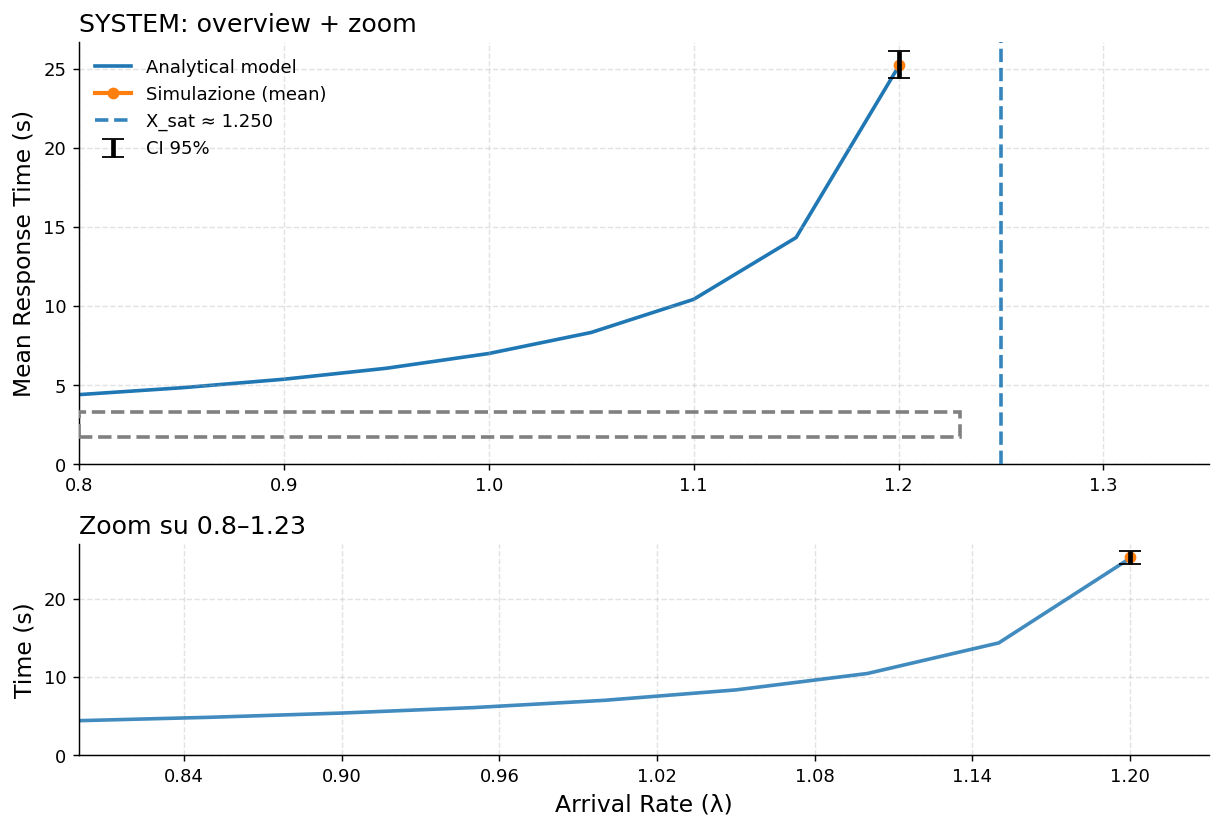

In [11]:
# SYSTEM con zoom sulla coda verso saturazione
df_all = load_runs(files)

plot_system_rt(df_all,analytic_df, zoom_range=(0.8, 1.23)) #usare questo per obj1 e 2 
#plot_system_rt(df_all, zoom_range=(1.21, 1.43)) #usare questo per obj3



In [12]:
# =======================
# POPULATION PLOT (v3) — sim (CI) vs analitico (da CSV)
# =======================

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pandas as pd

# ---- palette opzionale (riusa PALETTE se definita altrove) ----
def _pal(key, default):
    try:
        return PALETTE[key]  # noqa: F821
    except Exception:
        return default

# ---- banda+linea+CI per la simulazione ----
def _draw_ci_banded(ax, x, mean, half, *, color,
                    label_line="simulation (mean)",
                    label_band="simulation CI band",
                    label_ci="CI 95%",
                    min_display_half=0.0, ci_fill=True):
    x = np.asarray(x, float); mu = np.asarray(mean, float)
    h  = np.maximum(np.asarray(half, float), 0.0)

    if min_display_half > 0:
        h = np.maximum(h, float(min_display_half))

    lo, hi = mu - h, mu + h

    band_patch = None
    if ci_fill:
        ax.fill_between(x, lo, hi, color=color, alpha=0.18, linewidth=0, zorder=2)
        band_patch = mpatches.Patch(color=color, alpha=0.18, label=label_band)

    (line_handle,) = ax.plot(
        x, mu, "o-", color=color, linewidth=2.0, zorder=3,
        markevery=max(1, len(x)//40), label=label_line
    )

    yerr = np.vstack([mu - lo, hi - mu])
    ax.errorbar(x, mu, yerr=yerr, fmt="none",
                ecolor="black", elinewidth=2.4, capsize=6, zorder=4)
    ci_proxy = Line2D([0], [0], color="black", linewidth=2.4, label=label_ci)

    return (line_handle, band_patch, ci_proxy)

# ---- semi-ampiezza CI per OVERALL/NODE_* (usa std intra-run se serve) ----
def _ci_half_from_df(
    df_scope: pd.DataFrame,
    *,
    n_rep: int,
    conf: float,
    ci_design_effect: float,
    mean_col: str = "mean_population",
    std_col: str  = "std_population",
    n_departures_col: str | None = "num_departures",
) -> pd.DataFrame:
    # z 95% default
    def _z_value(c=0.95):
        if abs(c-0.95) < 1e-12: return 1.959963984540054
        lookup = {0.90: 1.6448536269514722, 0.95: 1.959963984540054, 0.975: 2.241402727604947, 0.99: 2.5758293035489004}
        return lookup.get(c, 1.959963984540054)

    z = _z_value(conf)
    df = df_scope.copy()

    for c in ["arrival_rate", mean_col, std_col]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if n_departures_col and n_departures_col in df.columns:
        df[n_departures_col] = pd.to_numeric(df[n_departures_col], errors="coerce")

    rows_per_lambda = (df.groupby("arrival_rate")[mean_col]
                         .count()
                         .rename("R")
                         .reset_index())

    out_rows = []
    for lam, g in df.groupby("arrival_rate", sort=True):
        R_here = int(rows_per_lambda.loc[rows_per_lambda["arrival_rate"] == lam, "R"].values[0])

        if R_here >= 2:
            m = float(g[mean_col].mean())
            s = float(g[mean_col].std(ddof=1)) if R_here > 1 else 0.0
            half = z * s / math.sqrt(R_here)
        else:
            m = float(g[mean_col].iloc[0])
            std_intra = float(g[std_col].iloc[0]) if (std_col in g.columns and pd.notna(g[std_col].iloc[0])) else 0.0
            if n_departures_col and n_departures_col in g.columns and pd.notna(g[n_departures_col].iloc[0]):
                n_eff = max(1.0, float(g[n_departures_col].iloc[0]) / float(ci_design_effect))
                half  = z * std_intra / math.sqrt(n_eff)
            else:
                half  = z * std_intra * math.sqrt(float(ci_design_effect))

        out_rows.append({"arrival_rate": float(lam), "mean": m, "half": max(0.0, half)})

    return (pd.DataFrame(out_rows)
              .sort_values("arrival_rate")
              .reset_index(drop=True))

# ---- collasso per λ (una sola barra CI a λ) ----
def _collapse_by_lambda(ci_df: pd.DataFrame, how: str = "mean") -> pd.DataFrame:
    if how == "mean":
        agg = {"mean": "mean", "half": "mean"}
    elif how == "max":
        agg = {"mean": "mean", "half": "max"}
    elif how == "min":
        agg = {"mean": "mean", "half": "min"}
    else:
        raise ValueError("how must be 'mean'/'max'/'min'")
    return (ci_df.groupby("arrival_rate", as_index=False)
                 .agg(agg).sort_values("arrival_rate").reset_index(drop=True))

# ---- helper: popolazione analitica per nodo dal CSV ----
def _analytic_node_population(model_df: pd.DataFrame, node: str) -> pd.Series | None:
    """
    Restituisce la serie N_node analitica:
    - Se esiste 'mean_population_{node}', usa quella.
    - Altrimenti se esiste 'util_{node}', calcola N = rho / (1 - rho) con clipping vicino a 1.
    - Altrimenti None.
    """
    # 1) popolazione nodo precomputata?
    col_pop = f"mean_population_{node}"
    if col_pop in model_df.columns:
        return pd.to_numeric(model_df[col_pop], errors="coerce")

    # 2) calcolo da rho (util_node)
    col_rho = f"util_{node}"
    if col_rho in model_df.columns:
        rho = pd.to_numeric(model_df[col_rho], errors="coerce").astype(float)
        # clipping per stabilità numerica vicino a 1
        rho = rho.clip(upper=1.0 - 1e-9)
        with np.errstate(divide="ignore", invalid="ignore"):
            N = rho / (1.0 - rho)
        N[~np.isfinite(N)] = np.nan
        return N

    return None

# ---------------- FUNZIONE PRINCIPALE ----------------
def plot_finite_population_with_analytic(
    files_or_path,
    analytic_df: pd.DataFrame,   # CSV analitico già caricato (tutte le colonne)
    *,
    n_rep: int,
    conf: float = 0.95,
    ci_design_effect: float = 12.0,
    ci_fill: bool = True,
    min_display_half: float = 0.0,
    node_order: list[str] | None = None,
    collapse_how: str = "mean",
    cols: int = 2,
    figsize=(12, 9),
    savepath: str | None = None,
    title: str = "Simulation vs Analytical model — Population",
):
    """
    - Simulazione: media ± CI su SYSTEM e su ogni nodo presente.
    - Analitico (CSV): SYSTEM da 'mean_population'; NODO da:
        mean_population_{node}  oppure  util_{node} -> N = rho/(1-rho).
    """
    # ---- dati simulazione ----
    df = _ensure_df(files_or_path)       # definita in una cella precedente
    detected = _detect_nodes(df)         # definita in una cella precedente
    nodes = ([n for n in (node_order or []) if n in detected] +
             [n for n in detected if not node_order or n not in node_order])

    sys_df  = df[df["vscope"] == "OVERALL"].copy()
    node_df = {n: df[df["vscope"] == f"NODE_{n}"].copy() for n in nodes}

    # CI simulazione
    sys_ci  = _ci_half_from_df(sys_df,  n_rep=n_rep, conf=conf, ci_design_effect=ci_design_effect)
    node_ci = {n: _ci_half_from_df(node_df[n], n_rep=n_rep, conf=conf, ci_design_effect=ci_design_effect)
               for n in nodes}

    # collassa per λ
    sys_ci  = _collapse_by_lambda(sys_ci,  how=collapse_how)
    node_ci = {n: _collapse_by_lambda(d, how=collapse_how) for n, d in node_ci.items()}

    # ---- modello analitico dal CSV (tutte le colonne) ----
    model = analytic_df.copy()
    if "lambda" in model.columns and "arrival_rate" not in model.columns:
        model = model.rename(columns={"lambda": "arrival_rate"})
    # SYSTEM
    if "mean_population" in model.columns and "SYS" not in model.columns:
        model = model.rename(columns={"mean_population": "SYS"})
    # ordina per sicurezza
    model = model.sort_values("arrival_rate").reset_index(drop=True)

    # ---- layout ----
    n_panels = 1 + len(nodes)
    rows = math.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.suptitle(title, y=0.98)

    col_sim = _pal("SIM", "#ff7f0e")
    col_the = _pal("THEORY", "#1f77b4")

    # ===== SYSTEM =====
    ax = axs[0]
    line_h, band_h, ci_h = _draw_ci_banded(
        ax,
        x=sys_ci["arrival_rate"], mean=sys_ci["mean"], half=sys_ci["half"],
        color=col_sim, label_line="simulation (mean)",
        label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
        min_display_half=min_display_half, ci_fill=ci_fill
    )
    handles = [line_h]
    if band_h is not None: handles.append(band_h)
    handles.append(ci_h)

    if "SYS" in model.columns:
        (h_model,) = ax.plot(
            model["arrival_rate"], model["SYS"],
            color=col_the, linewidth=2.3, linestyle="--",
            marker="s", markersize=4, label="analytical model", zorder=6
        )
        handles.append(h_model)

    # X_max (asintoto) se presente
    x_max = None
    if "X_max" in model.columns and pd.notna(model["X_max"].iloc[0]):
        try:
            x_max = float(model["X_max"].iloc[0])
        except Exception:
            x_max = None
    if x_max is not None and np.isfinite(x_max):
        ax.axvline(x_max, linestyle="--", color=col_the, alpha=0.8, linewidth=1.8, label=f"X_max ≈ {x_max:.3g}")

    ax.set_title("SYSTEM average population")
    ax.set_xlabel("Lambda"); ax.set_ylabel("Avg population in SYSTEM")
    ax.legend(handles=handles, loc="upper left")

    # ===== NODI =====
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d = node_ci[n]
        line_h, band_h, ci_h = _draw_ci_banded(
            ax,
            x=d["arrival_rate"], mean=d["mean"], half=d["half"],
            color=col_sim, label_line="simulation (mean)",
            label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
            min_display_half=min_display_half, ci_fill=ci_fill
        )
        handles = [line_h]
        if band_h is not None: handles.append(band_h)
        handles.append(ci_h)

        # analitico del nodo: prima prova colonna mean_population_{n}, altrimenti N = rho/(1-rho) da util_{n}
        N_node = _analytic_node_population(model, n)
        if N_node is not None:
            (h_model,) = ax.plot(
                model["arrival_rate"], N_node,
                color=col_the, linewidth=2.3, linestyle="--",
                marker="s", markersize=4, label="analytical model", zorder=6
            )
            handles.append(h_model)

        ax.set_title(f"{n} average population")
        ax.set_xlabel("Lambda"); ax.set_ylabel(f"Avg population in {n}")
        ax.legend(handles=handles, loc="upper left")

    # pannelli extra invisibili
    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig


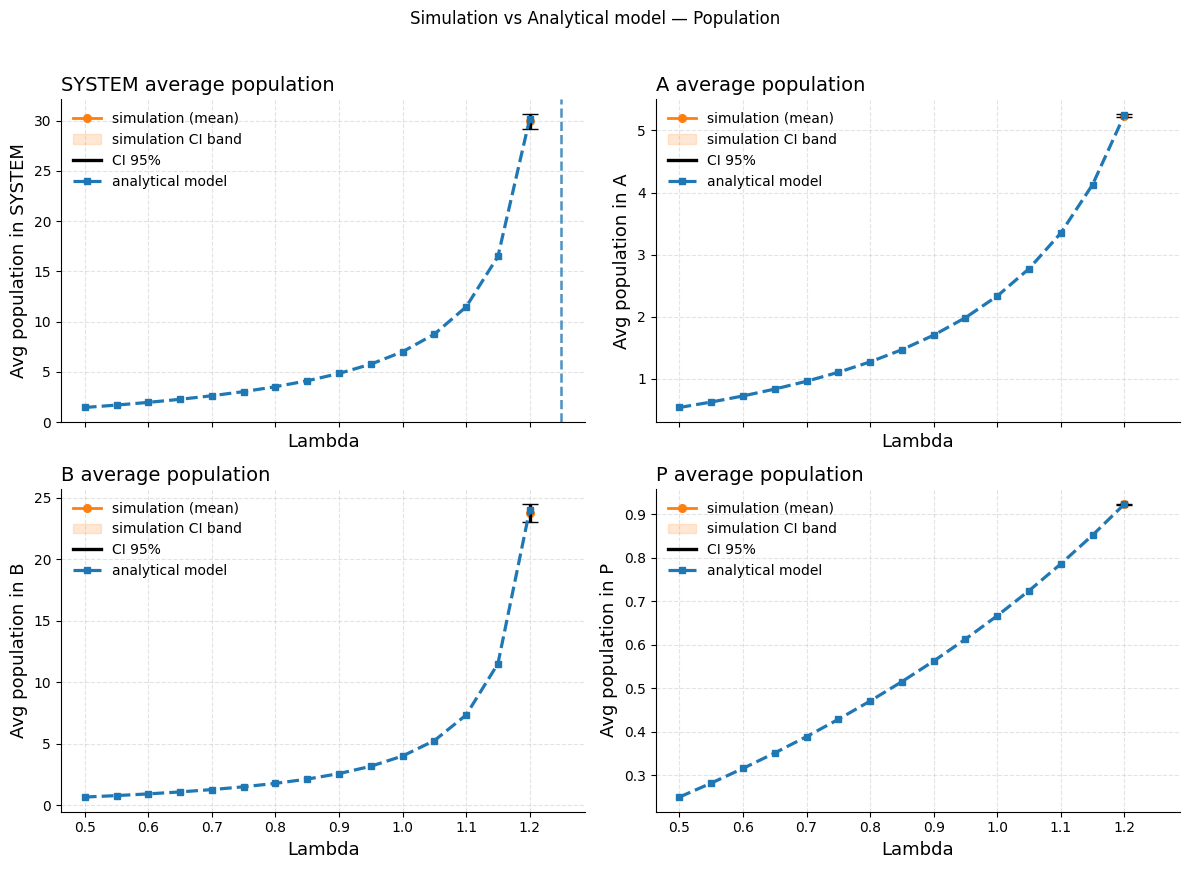

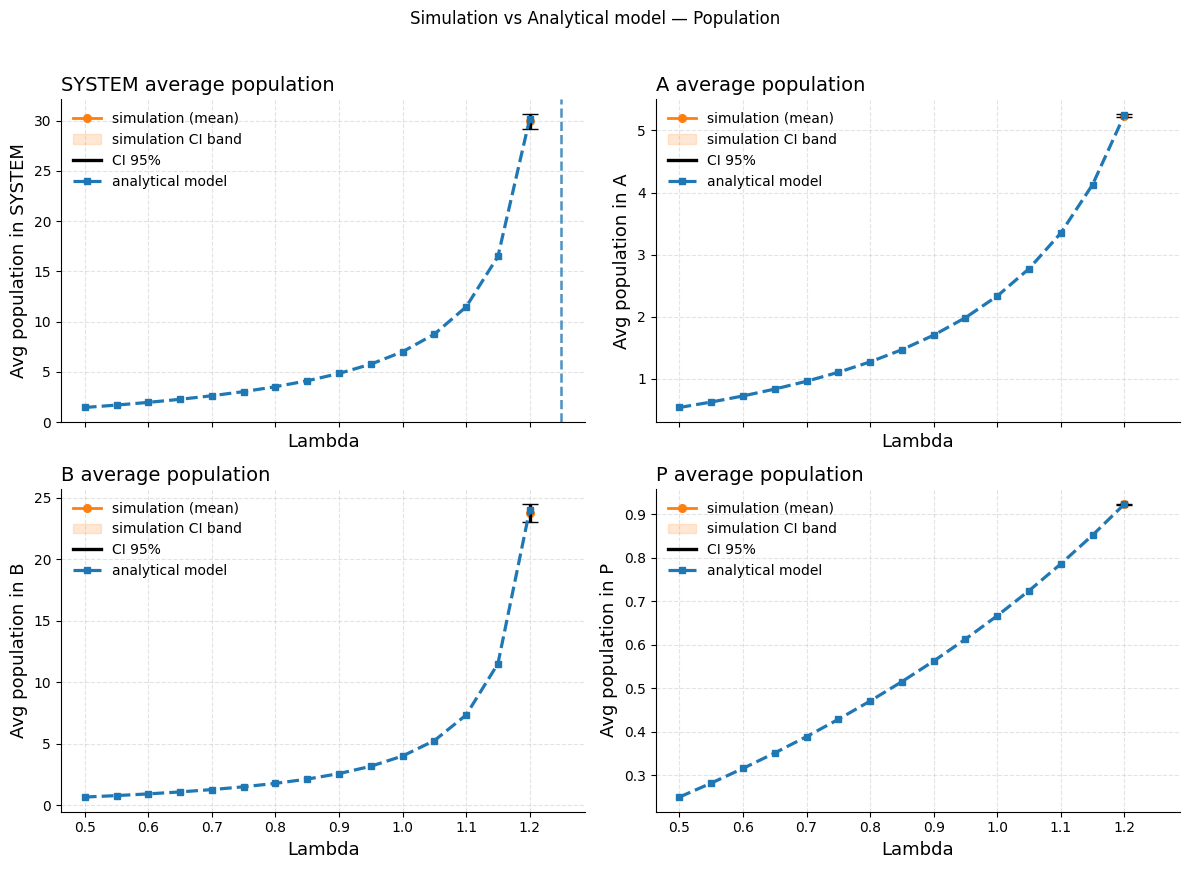

In [13]:


plot_finite_population_with_analytic(
    files_or_path=files,
    analytic_df=analytic_df,      # <-- obbligatorio: usa SEMPRE il CSV analitico che gli passi
    n_rep=5,
    conf=0.95,
    ci_design_effect=12.0,        # fallback solo quando per un λ hai una sola riga
    ci_fill=True,                 # False per togliere la banda arancione
    min_display_half=0.0,
    node_order=["A", "B", "P"],
    collapse_how="mean",          # "max" se vuoi CI più conservativi
    figsize=(12, 9)
)

In [14]:
# ================================
# RESPONSE TIME — nuovo stile (v3) SOLO CSV ANALITICO (SYSTEM)
# Usa _pal, _z_value, _ensure_df, _detect_nodes dalle celle precedenti
# ================================

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pandas as pd

# --- half-width del CI con nomi di colonna configurabili (solo simulazione) ---
def _ci_half_from_df_generic(
    df_scope: pd.DataFrame,
    *,
    n_rep: int,
    conf: float,
    ci_design_effect: float,
    mean_col: str,
    std_col: str,
    n_departures_col: str | None = "num_departures",
    std_scale: float = 1.0,    # es. 0.001 se std è in ms e la mean in s
) -> pd.DataFrame:
    """
    Ritorna un DF con colonne: arrival_rate, mean, half.
    - Se per un λ ci sono >=2 righe (repliche): usa la varianza *tra repliche* delle MEDIE.
    - Se c'è 1 sola riga: fallback con n_eff = departures / ci_design_effect (>=1).
    """
    z = _z_value(conf)  # <-- già definito sopra

    df = df_scope.copy()
    for c in [mean_col, std_col, "arrival_rate"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if n_departures_col and n_departures_col in df.columns:
        df[n_departures_col] = pd.to_numeric(df[n_departures_col], errors="coerce")

    rows_per_lambda = (df.groupby("arrival_rate")[mean_col]
                         .count()
                         .rename("R")
                         .reset_index())

    out_rows = []
    for lam, g in df.groupby("arrival_rate", sort=True):
        R_here = int(rows_per_lambda.loc[rows_per_lambda["arrival_rate"] == lam, "R"].values[0])

        if R_here >= 2:
            m = float(g[mean_col].mean())
            s = float(g[mean_col].std(ddof=1)) if R_here > 1 else 0.0
            half = z * s / math.sqrt(R_here)
        else:
            m = float(g[mean_col].iloc[0])
            std_intra = float(g[std_col].iloc[0]) * float(std_scale) if pd.notna(g[std_col].iloc[0]) else 0.0
            if n_departures_col and n_departures_col in g.columns and pd.notna(g[n_departures_col].iloc[0]):
                n_eff = max(1.0, float(g[n_departures_col].iloc[0]) / float(ci_design_effect))
                half = z * std_intra / math.sqrt(n_eff)
            else:
                half = z * std_intra * math.sqrt(float(ci_design_effect))

        out_rows.append({"arrival_rate": float(lam), "mean": m, "half": max(0.0, half)})

    return (pd.DataFrame(out_rows)
              .sort_values("arrival_rate")
              .reset_index(drop=True))


# --- collassa duplicati su λ -> UNA SOLA barra CI per λ ---
def _collapse_by_lambda(ci_df: pd.DataFrame, how: str = "mean") -> pd.DataFrame:
    """Accetta [arrival_rate, mean, half] e collassa per λ."""
    if how == "mean":
        agg = {"mean": "mean", "half": "mean"}
    elif how == "max":
        agg = {"mean": "mean", "half": "max"}
    elif how == "min":
        agg = {"mean": "mean", "half": "min"}
    else:
        raise ValueError("how must be 'mean'/'max'/'min'")
    return (ci_df.groupby("arrival_rate", as_index=False)
                 .agg(agg).sort_values("arrival_rate").reset_index(drop=True))


# --- disegno: banda arancione + linea arancione + barre CI nere ---
def _draw_ci_banded(ax, x, mean, half, *, color,
                    label_line="simulation (mean)",
                    label_band="simulation CI band",
                    label_ci="CI 95%",
                    min_display_half: float = 0.0,
                    ci_fill: bool = True):
    """Ritorna gli handle per la legenda: (line_handle, band_patch, ci_proxy)."""
    x = np.asarray(x, float); mu = np.asarray(mean, float)
    h  = np.maximum(np.asarray(half, float), 0.0)
    if min_display_half > 0:
        h = np.maximum(h, float(min_display_half))
    lo, hi = mu - h, mu + h

    band_patch = None
    if ci_fill:
        ax.fill_between(x, lo, hi, color=color, alpha=0.18, linewidth=0, zorder=2)
        band_patch = mpatches.Patch(color=color, alpha=0.18, label=label_band)

    (line_handle,) = ax.plot(
        x, mu, "o-", color=color, linewidth=2.0, zorder=3,
        markevery=max(1, len(x)//40), label=label_line
    )

    yerr = np.vstack([mu - lo, hi - mu])
    ax.errorbar(x, mu, yerr=yerr, fmt="none",
                ecolor="black", elinewidth=2.4, capsize=6, zorder=4)
    ci_proxy = Line2D([0], [0], color="black", linewidth=2.4, label=label_ci)
    return (line_handle, band_patch, ci_proxy)


# --- PLOT: simulazione (CI) + curva analitica del CSV per SYSTEM ---
def plot_finite_response_time_banded_v3(
    files_or_path,
    analytic_df: pd.DataFrame,            # <-- CSV analitico con 'arrival_rate' e 'mean_response_time'
    *,
    n_rep: int,
    conf: float = 0.95,
    ci_design_effect: float = 12.0,
    ci_fill: bool = True,
    min_display_half: float = 0.0,
    mean_col: str = "mean_response_time",
    std_col: str  = "std_response_time",
    node_order: list[str] | None = None,
    collapse_how: str = "mean",
    cols: int = 2,
    figsize=(12, 9),
    savepath: str | None = None,
    title: str = "Confidence interval for average response time",
    ylabel_unit: str = "s"
):
    # 1) carica DF di simulazione (usa utilità già definite sopra)
    df = _ensure_df(files_or_path)

    # 2) nodi presenti
    detected = _detect_nodes(df)
    nodes = ([n for n in (node_order or []) if n in detected] +
             [n for n in detected if (not node_order or n not in node_order)])

    # 3) split per scope
    df["vscope"] = df["vscope"].astype(str)
    sys_df  = df[df["vscope"] == "OVERALL"].copy()
    node_df = {n: df[df["vscope"] == f"NODE_{n}"].copy() for n in nodes}

    # 4) CI simulazione (SYSTEM + NODI) e collasso per λ
    sys_ci  = _ci_half_from_df_generic(sys_df,  n_rep=n_rep, conf=conf,
                                       ci_design_effect=ci_design_effect,
                                       mean_col=mean_col, std_col=std_col)
    node_ci = {n: _ci_half_from_df_generic(node_df[n], n_rep=n_rep, conf=conf,
                                           ci_design_effect=ci_design_effect,
                                           mean_col=mean_col, std_col=std_col)
               for n in nodes}
    sys_ci  = _collapse_by_lambda(sys_ci,  how=collapse_how)
    node_ci = {n: _collapse_by_lambda(d, how=collapse_how) for n, d in node_ci.items()}

    # 5) modello analitico dal CSV (SOLO SYSTEM)
    model = analytic_df.copy()
    if "lambda" in model.columns:
        model = model.rename(columns={"lambda": "arrival_rate"})
    if "mean_response_time" not in model.columns or "arrival_rate" not in model.columns:
        raise ValueError("analytic_df deve contenere almeno 'arrival_rate' e 'mean_response_time'.")
    model = model.sort_values("arrival_rate").reset_index(drop=True)

    # 6) layout
    n_panels = 1 + len(nodes)
    rows = math.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.suptitle(title, y=0.98)

    col_sim = _pal("SIM",    "#ff7f0e")  # <-- definito sopra
    col_the = _pal("THEORY", "#1f77b4")  # <-- definito sopra

    # --- SYSTEM ---
    ax = axs[0]
    line_h, band_h, ci_h = _draw_ci_banded(
        ax,
        x=sys_ci["arrival_rate"], mean=sys_ci["mean"], half=sys_ci["half"],
        color=col_sim, label_line="simulation (mean)",
        label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
        min_display_half=min_display_half, ci_fill=ci_fill
    )
    handles = [line_h] + ([band_h] if band_h is not None else []) + [ci_h]

    (h_model,) = ax.plot(
        model["arrival_rate"], model["mean_response_time"],
        color=col_the, linewidth=2.3, linestyle="--",
        marker="s", markersize=4, label="analytical model", zorder=6
    )
    handles.append(h_model)

    # linea verticale a X_max (se presente)
    if "X_max" in model.columns and pd.notna(model["X_max"]).any():
        try:
            Xsat = float(model["X_max"].dropna().iloc[0])
            ax.axvline(Xsat, linestyle="--", color=col_the, alpha=0.9, linewidth=2.0, label=f"X_max ≈ {Xsat:.3f}")
        except Exception:
            pass

    ax.set_title("SYSTEM average response time")
    ax.set_xlabel("Lambda"); ax.set_ylabel(f"Avg response time in SYSTEM [{ylabel_unit}]")
    ax.legend(handles=handles, loc="upper left")

    # --- NODI (solo simulazione) ---
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d = node_ci[n]
        line_h, band_h, ci_h = _draw_ci_banded(
            ax,
            x=d["arrival_rate"], mean=d["mean"], half=d["half"],
            color=col_sim, label_line="simulation (mean)",
            label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
            min_display_half=min_display_half, ci_fill=ci_fill
        )
        handles = [line_h] + ([band_h] if band_h is not None else []) + [ci_h]
        ax.set_title(f"{n} average response time")
        ax.set_xlabel("Lambda"); ax.set_ylabel(f"Avg response time in {n} [{ylabel_unit}]")
        ax.legend(handles=handles, loc="upper left")

    # pannelli extra
    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig


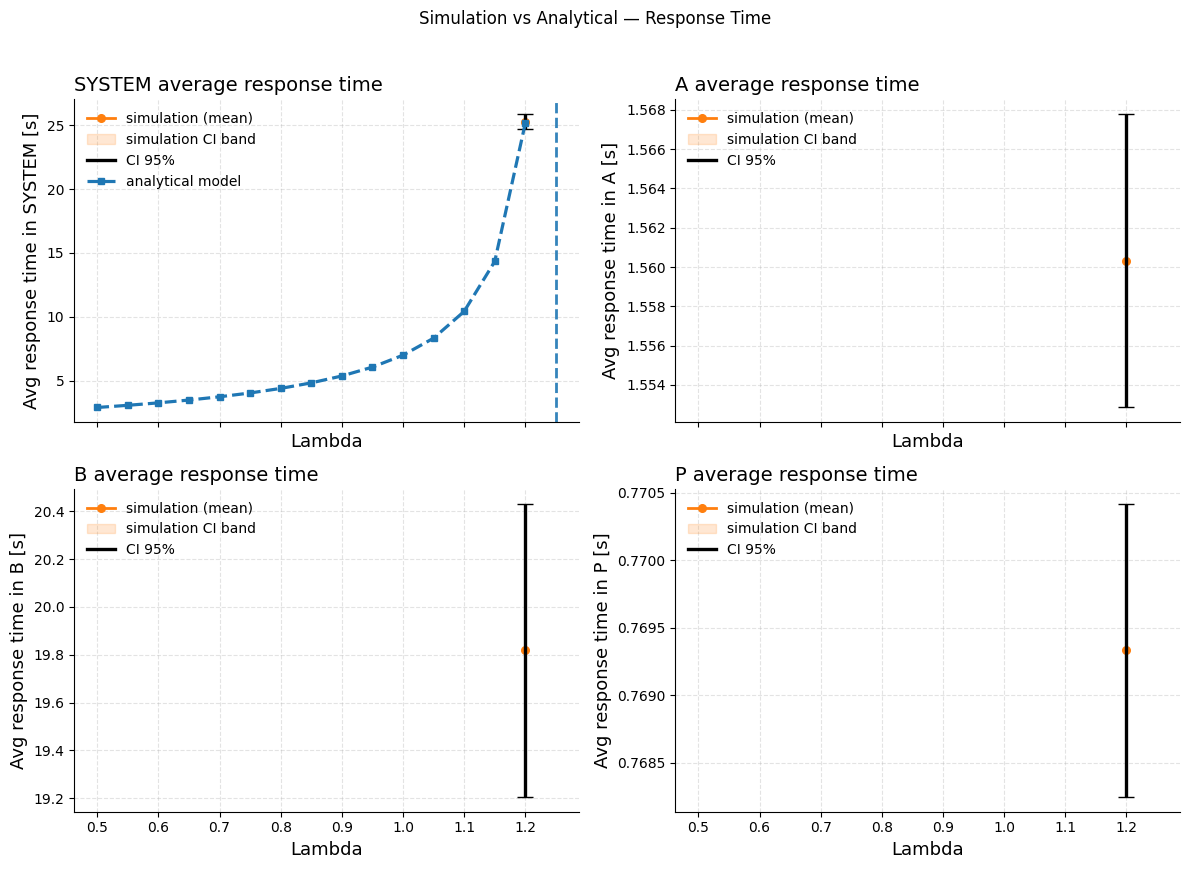

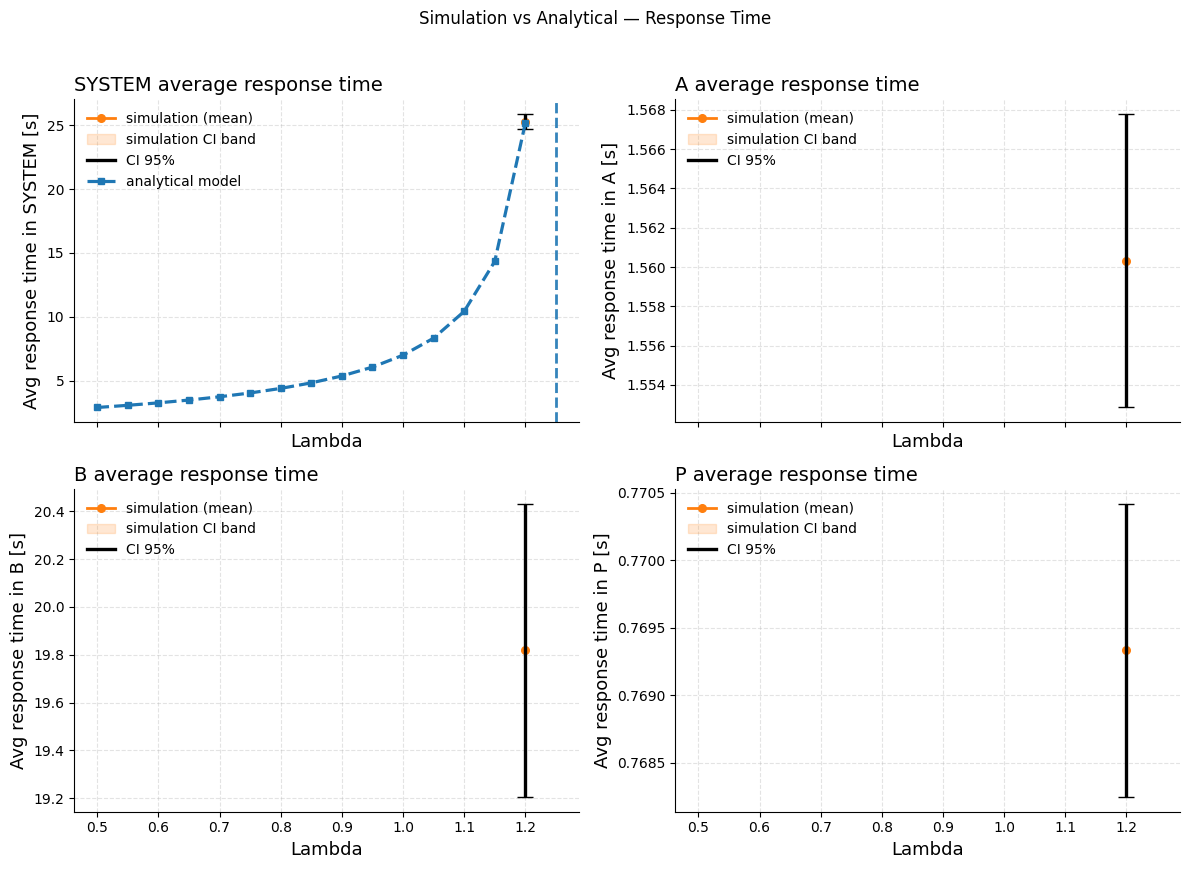

In [15]:
# df di simulazione -> 'files' (lista di CSV) o un singolo CSV/DF
# analytic_df -> il CSV analitico già caricato (con 'arrival_rate','mean_response_time', opz. 'X_max')

plot_finite_response_time_banded_v3(
    files_or_path=files,
    analytic_df=analytic_df,
    n_rep=5,
    conf=0.95,
    ci_design_effect=12.0,
    ci_fill=True,
    min_display_half=0.0,
    node_order=["A", "B", "P"],
    collapse_how="mean",
    figsize=(12, 9),
    title="Simulation vs Analytical — Response Time"
)



In [16]:
def plot_nodes_rt(
    files_or_path,
    analytic_df: pd.DataFrame,                 # <-- CSV analitico con: arrival_rate, X_max, util_A/util_B/..., ecc.
    *,
    nodes: tuple[str, ...] | None = None,
    width: float = 9.5,
    height: float = 5.2,
    dpi: int = 130,
    zoom_range: tuple[float, float] | None = (0.8, 1.21),
    x_overview_cap: float = 1.6,
    right_pad_ratio: float = 0.06,
    y_cap_overview: float | None = None,
    y_cap_zoom: float | None = None,
    percentile_cap: float = 99.0,
    per_job_nodes: set[str] = frozenset(),     # se un nodo è qui: R_job = v_i * R_visit
    visits: dict[str, float] = None,           # visite per nodo (serve solo per la vista per-visita)
    zoom_box_frac: float = 0.06,               # altezza del box grigio nell’overview (6%)
    n_rep: int = 5,
    conf: float = 0.95,
    ci_design_effect: float = 12.0,
):
    """
    NODES response time: overview = media simulazione; zoom = media ± CI.
    La curva teorica per nodo i viene dal CSV analitico usando:
      - ρ_i = util_<i>
      - λ = arrival_rate
      - v_i (visits) se serve la vista per-visita.
    Formula M/M/1:
      R_visit_i = ρ_i / (λ v_i (1-ρ_i))
      R_job_i   = v_i * R_visit_i = ρ_i / (λ (1-ρ_i))      (indipendente da v_i)
    """
    # --- setup visite ---
    if visits is None:
        visits = {"A": 3.0, "B": 1.0, "P": 1.0}

    # --- carica DF simulazione ---
    df = _ensure_df(files_or_path)  # usa utilità già definite nella cella precedente
    df_nodes = df[df["vscope"].astype(str).str.startswith("NODE_")].copy()
    if df_nodes.empty or "mean_response_time" not in df_nodes.columns:
        print("Mancano dati NODE_*/mean_response_time.")
        return

    # --- set nodi da plottare ---
    detected = sorted([s.replace("NODE_", "") for s in df_nodes["vscope"].unique()])
    if nodes is None:
        nodes_list = detected
    else:
        nodes_list = [n for n in nodes if n in detected]
    if not nodes_list:
        print("Nessun nodo da plottare dopo il filtro.")
        return

    # --- CI per nodo (simulazione) ---
    def ci_node(n: str) -> pd.DataFrame:
        sub = df_nodes[df_nodes["vscope"] == f"NODE_{n}"].copy()
        ci = _ci_half_from_df_generic(
            sub,
            n_rep=n_rep, conf=conf, ci_design_effect=ci_design_effect,
            mean_col="mean_response_time", std_col="std_response_time",
        )
        return _collapse_by_lambda(ci, how="mean")

    agg_by_node = {n: ci_node(n) for n in nodes_list}

    # --- X_sat dal CSV analitico + dati teorici per nodo dal CSV ---
    model = analytic_df.copy()
    if "lambda" in model.columns and "arrival_rate" not in model.columns:
        model = model.rename(columns={"lambda": "arrival_rate"})
    # ordina e prendi X_max (se presente)
    model = model.sort_values("arrival_rate").reset_index(drop=True)
    X_sat = None
    if "X_max" in model.columns and pd.notna(model["X_max"]).any():
        try:
            X_sat = float(model["X_max"].dropna().iloc[0])
        except Exception:
            X_sat = None

    # costruiamo una funzione teorica sui punti del CSV (niente stime interne)
    def theory_series_for_node(n: str) -> pd.DataFrame | None:
        col_rho = f"util_{n}"
        if col_rho not in model.columns:
            return None
        lam = model["arrival_rate"].to_numpy(float)
        rho = model[col_rho].to_numpy(float)
        v_i = float(visits.get(n, 1.0))

        # per-visit e per-job
        with np.errstate(divide="ignore", invalid="ignore"):
            R_visit = rho / (lam * v_i * (1.0 - rho))
            R_job   = rho / (lam * (1.0 - rho))
        # maschera valori non fisici (rho>=1 o non finiti)
        mask = np.isfinite(R_visit) & (rho < 1.0 - 1e-12) & np.isfinite(lam) & (lam > 0)
        R_visit = np.where(mask, R_visit, np.nan)
        R_job   = np.where(mask, R_job,   np.nan)

        out = pd.DataFrame({"arrival_rate": lam})
        out["R_visit"] = R_visit
        out["R_job"]   = R_job
        return out

    theory_by_node = {n: theory_series_for_node(n) for n in nodes_list}

    # --- range X (overview) ---
    x_all = pd.concat([agg_by_node[n]["arrival_rate"] for n in nodes_list], ignore_index=True)
    x_min, x_max = float(np.nanmin(x_all)), float(np.nanmax(x_all))
    if zoom_range is None:
        x_overview_min = x_min
        x_target_max = x_max
    else:
        x_overview_min = min(x_min, zoom_range[0])
        x_target_max = max(x_max, zoom_range[1])
    if X_sat is not None:
        x_target_max = max(x_target_max, X_sat * 1.02)
    x_overview_max = min(x_target_max * (1.0 + right_pad_ratio), x_overview_cap)

    # --- helper di disegno ---
    def draw_mean(ax, g: pd.DataFrame, *, color, label):
        x = g["arrival_rate"].to_numpy(float)
        m = g["mean"].to_numpy(float)
        ax.plot(x, m, "o-", linewidth=2.0, color=color, label=label, zorder=3)
        return m

    def draw_mean_ci(ax, g: pd.DataFrame, *, color, label):
        x  = g["arrival_rate"].to_numpy(float)
        m  = g["mean"].to_numpy(float)
        lo = m - g["half"].to_numpy(float)
        hi = m + g["half"].to_numpy(float)
        ax.errorbar(x, m, yerr=[m - lo, hi - m], fmt="o-", color=color,
                    ecolor=color, elinewidth=2.0, capsize=5, alpha=0.9, linewidth=2.0,
                    label=label, zorder=4)
        return m, lo, hi

    def auto_cap(pool):
        vals = np.hstack([p[np.isfinite(p)] for p in pool if p is not None] or [])
        if vals.size:
            cap = np.nanpercentile(vals, percentile_cap) * 1.05
            return float(cap) if np.isfinite(cap) else None
        return None

    # --- figure: overview + zoom ---
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(width, height * 1.35), dpi=dpi,
        gridspec_kw={"height_ratios": [2, 1]}
    )

    pool_o, pool_z = [], []

    for n in nodes_list:
        col = PALETTE.get(n, "#333333")  # usa la tua palette se definita
        lbl = f"Node {n}"

        # overview → SOLO mean simulazione
        m_o = draw_mean(ax1, agg_by_node[n], color=col, label=f"{lbl} (mean)")
        pool_o.append(m_o)

        # zoom → mean ± CI simulazione
        m_z, lo_z, hi_z = draw_mean_ci(ax2, agg_by_node[n], color=col, label=f"{lbl} (mean ± CI)")
        pool_z.extend([m_z, lo_z, hi_z])

        # teoria dal CSV
        th = theory_by_node[n]
        if th is not None:
            series = "R_job" if n in per_job_nodes else "R_visit"
            y_over = th[(th["arrival_rate"] >= x_overview_min) & (th["arrival_rate"] <= x_overview_max)][series].to_numpy(float)
            x_over = th[(th["arrival_rate"] >= x_overview_min) & (th["arrival_rate"] <= x_overview_max)]["arrival_rate"].to_numpy(float)
            if np.isfinite(y_over).any():
                ax1.plot(x_over, y_over, color=col, linestyle="--", linewidth=1.8, alpha=0.9, label=f"{lbl} theory", zorder=2)
                pool_o.append(y_over)

            if zoom_range is not None:
                maskz = (th["arrival_rate"] >= zoom_range[0]) & (th["arrival_rate"] <= zoom_range[1])
                x_zoom = th.loc[maskz, "arrival_rate"].to_numpy(float)
                y_zoom = th.loc[maskz, series].to_numpy(float)
                if np.isfinite(y_zoom).any():
                    ax2.plot(x_zoom, y_zoom, color=col, linestyle="--", linewidth=1.8, alpha=0.9, label=f"{lbl} theory", zorder=2)
                    pool_z.append(y_zoom)

    # X_sat (se noto)
    if X_sat is not None:
        if x_overview_min <= X_sat <= x_overview_max:
            ax1.axvline(X_sat, linestyle="--", color=PALETTE.get("THEORY", "#1f77b4"),
                        alpha=0.9, linewidth=2.0, label="X_max")
        if zoom_range and (zoom_range[0] <= X_sat <= zoom_range[1]):
            ax2.axvline(X_sat, linestyle="--", color=PALETTE.get("THEORY", "#1f77b4"),
                        alpha=0.9, linewidth=2.0, label="X_max")

    # cap Y auto (se non forniti)
    if y_cap_overview is None:
        y_cap_overview = auto_cap(pool_o)
    if y_cap_zoom is None:
        y_cap_zoom = auto_cap(pool_z)

    # limiti assi
    ax1.set_xlim(x_overview_min, x_overview_max)
    if zoom_range is not None:
        ax2.set_xlim(*zoom_range)
    ax1.set_ylim(bottom=0, top=y_cap_overview)
    ax2.set_ylim(bottom=0, top=y_cap_zoom)

    # box grigio “zoom” nell’overview
    if zoom_range is not None:
        import matplotlib.patches as patches
        y0, y1 = ax1.get_ylim()
        ax1.add_patch(patches.Rectangle(
            (zoom_range[0], y0),
            zoom_range[1] - zoom_range[0],
            (y1 - y0) * float(zoom_box_frac),
            facecolor="none", edgecolor="gray", linestyle="--", linewidth=2.0, zorder=6
        ))

    # aspetto
    ax1.set_ylabel("Mean Response Time (s)")
    ax2.set_ylabel("Mean Response Time (s)")
    ax1.set_title(f"{TITLE_PREFIX} — NODES: overview + zoom" if 'TITLE_PREFIX' in globals() else "NODES: overview + zoom")
    if zoom_range:
        ax2.set_title(f"Zoom su {zoom_range[0]:.3g}–{zoom_range[1]:.3g}")
    ax1.grid(True, linestyle="--", alpha=0.35)
    ax2.grid(True, linestyle="--", alpha=0.35)

    # legende (dedup)
    for ax in (ax1, ax2):
        h, l = ax.get_legend_handles_labels()
        uniq = dict(zip(l, h))
        ax.legend(uniq.values(), uniq.keys(), loc="upper left", fontsize=9)

    plt.tight_layout()
    plt.show()


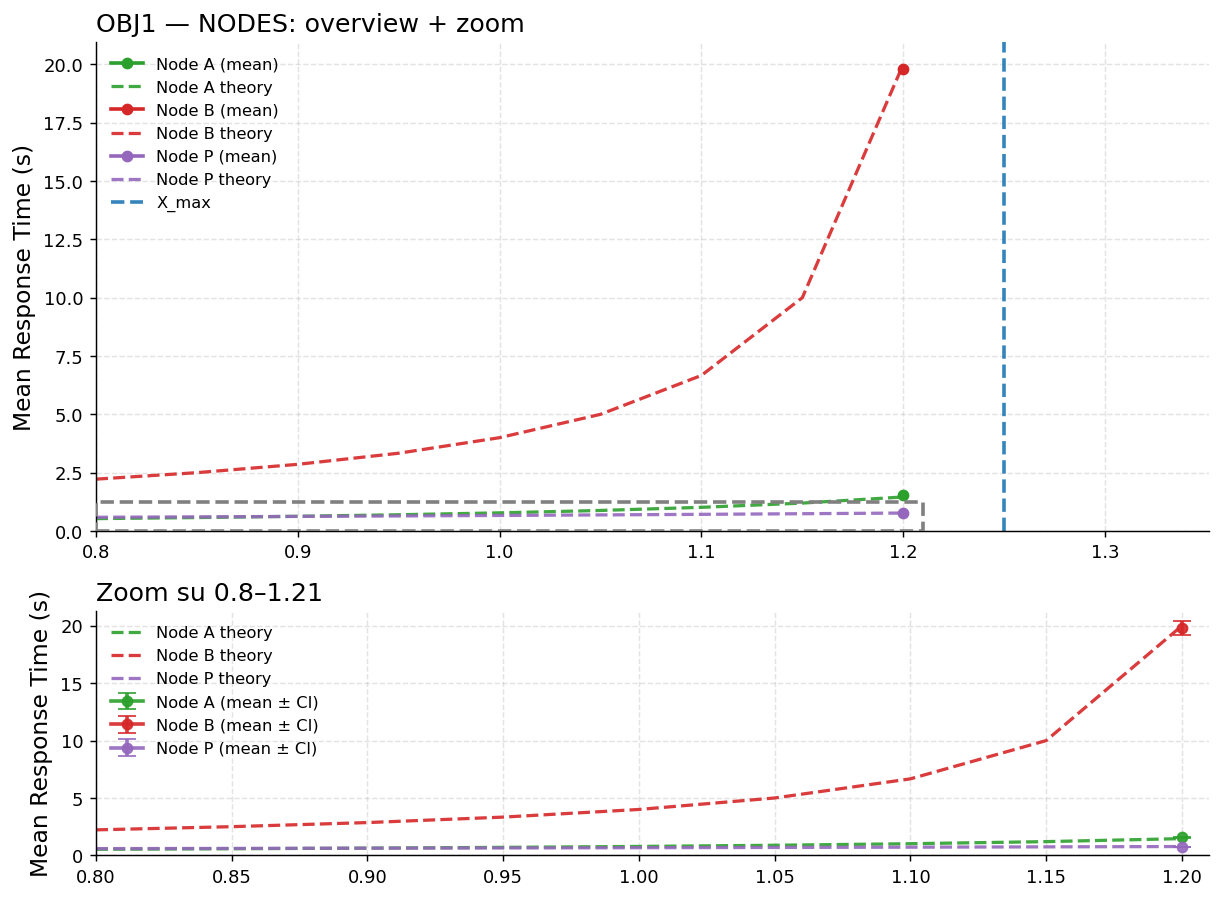

In [17]:

# fai il plot
plot_nodes_rt(
    files_or_path=files,      # qui passi i CSV di simulazione (lista o path)
    analytic_df=analytic_df,  # qui il CSV analitico già caricato
    nodes=("A", "B", "P"),    # opzionale: quali nodi plottare
    n_rep=5,
    conf=0.95,
    zoom_range=(0.8, 1.21),   # range X per lo zoom
    visits={"A": 3, "B": 1, "P": 1},   # le visite che vuoi
    per_job_nodes=set(),      # se vuoi per-job, metti ad es. {"A"} ecc.
)


In [18]:
# ================================
# SYSTEM THROUGHPUT — usa analitico da CSV (niente residui)
# ================================

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t as student_t

def _pick_xcol(df: pd.DataFrame) -> tuple[str, str]:
    """Sceglie la X: preferisce 'arrival_rate', altrimenti 'replica' se esiste."""
    if "arrival_rate" in df.columns and df["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "replica" in df.columns:
        return "replica", "Replica"
    return "arrival_rate", "Arrival Rate (λ)"

def _collapse_scope_col(df: pd.DataFrame) -> pd.DataFrame:
    """Uniforma la colonna di scope: usa 'vscope' se presente, altrimenti 'scope'."""
    if "vscope" in df.columns:
        return df.rename(columns={"vscope": "scope"})
    return df

def _aggregate_throughput_ci(df_overall: pd.DataFrame,
                             xcol: str,
                             conf: float = 0.95) -> pd.DataFrame:
    """
    Media e IC *tra repliche* per il throughput.
    Se per una X c'è 1 sola riga → barra nulla.
    Ritorna colonne: [xcol, 'mean', 'ci_lo', 'ci_hi'] ordinate per X.
    """
    zt = lambda R: float(student_t.ppf(0.5 + conf/2.0, max(R-1, 1)))
    rows = []
    for x, g in df_overall.groupby(xcol, sort=True):
        vals = pd.to_numeric(g["throughput"], errors="coerce").dropna()
        if len(vals) == 0:
            continue
        m = float(vals.mean())
        if len(vals) >= 2:
            s = float(vals.std(ddof=1))
            half = zt(len(vals)) * s / math.sqrt(len(vals))
            lo, hi = m - half, m + half
        else:
            lo = hi = m
        rows.append({xcol: float(x), "mean": m, "ci_lo": lo, "ci_hi": hi})
    return pd.DataFrame(rows).sort_values(xcol).reset_index(drop=True)

def plot_system_throughput(df_all: pd.DataFrame,
                           analytic_df: pd.DataFrame,
                           *,
                           width: float = 8.6,
                           height: float = 4.6,
                           dpi: int = 130,
                           show_theory: bool = True,
                           clip_at_Xsat: bool = False,
                           ci_conf: float = 0.95):
    """
    Confronto throughput complessivo:
      - Simulazione: mean ± CI (da df_all['throughput'])
      - Analitico:   X(λ)=λ (da analytic_df['arrival_rate']), mascherato/plateau a X_max
    Nessun pannello dei residui.
    """
    # --- prepara OVERALL (simulazione)
    df = _collapse_scope_col(df_all.copy())
    overall_mask = df["scope"].astype(str).str.upper().eq("OVERALL")
    df_overall = df.loc[overall_mask].copy()
    if df_overall.empty or "throughput" not in df_overall.columns:
        print("Mancano dati OVERALL/throughput.")
        return

    xcol, xlabel = _pick_xcol(df_overall)
    agg = _aggregate_throughput_ci(df_overall, xcol=xcol, conf=ci_conf)

    # --- modello analitico dal CSV
    model = analytic_df.copy()
    if "lambda" in model.columns and "arrival_rate" not in model.columns:
        model = model.rename(columns={"lambda": "arrival_rate"})
    X_sat = float(model["X_max"].iloc[0]) if "X_max" in model.columns and pd.notna(model["X_max"]).any() else float("nan")
    model = model.sort_values("arrival_rate").reset_index(drop=True)

    x_theory = model["arrival_rate"].to_numpy(float)
    y_theory = x_theory.copy()  # X(λ)=λ
    if np.isfinite(X_sat):
        if clip_at_Xsat:
            y_theory = np.where(x_theory <= X_sat, x_theory, X_sat)
        else:
            y_theory = np.where(x_theory <= X_sat, x_theory, np.nan)

    # --- figura singola (niente residui)
    fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)

    # simulazione (mean ± CI)
    x  = agg[xcol].to_numpy(float)
    mu = agg["mean"].to_numpy(float)
    lo = np.where(np.isfinite(agg["ci_lo"]), agg["ci_lo"].to_numpy(float), mu)
    hi = np.where(np.isfinite(agg["ci_hi"]), agg["ci_hi"].to_numpy(float), mu)

    col_sim = (PALETTE.get("SIM", "#ff7f0e") if 'PALETTE' in globals() else "#ff7f0e")
    col_the = (PALETTE.get("THEORY", "#1f77b4") if 'PALETTE' in globals() else "#1f77b4")

    ax.plot(x, mu, "o-", linewidth=2.1, color=col_sim, label="Sim (mean)")
    ax.fill_between(x, lo, hi, alpha=0.18, linewidth=0, color=col_sim, label=f"CI {int(ci_conf*100)}%")

    # analitico + X_max
    if show_theory and xcol == "arrival_rate":
        ax.plot(x_theory, y_theory, color=col_the, linewidth=2.0,
                label=("Analytical (plateau)" if clip_at_Xsat else "Analytical"))
        if np.isfinite(X_sat):
            ax.axvline(X_sat, linestyle="--", color=col_the, alpha=0.9, linewidth=2.0,
                       label=f"X_max ≈ {X_sat:.3f}")

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Throughput X (req/s)")
    ttl = f"{TITLE_PREFIX} — SYSTEM: Throughput (sim vs analytical)" if 'TITLE_PREFIX' in globals() \
          else "SYSTEM: Throughput (sim vs analytical)"
    ax.set_title(ttl)
    ax.grid(True, linestyle="--", alpha=0.35)

    # legenda deduplicata
    h, l = ax.get_legend_handles_labels()
    uniq = dict(zip(l, h))
    ax.legend(uniq.values(), uniq.keys(), loc="upper left")

    plt.tight_layout()
    plt.show()


In [19]:
# ================================
# NODES THROUGHPUT — usa analitico da CSV (niente stime interne)
# ================================

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t as student_t

def _pick_xcol_nodes(df_nodes: pd.DataFrame) -> tuple[str, str]:
    """Sceglie la X: preferisce 'arrival_rate', altrimenti 'replica' se esiste."""
    if "arrival_rate" in df_nodes.columns and df_nodes["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "replica" in df_nodes.columns:
        return "replica", "Replica"
    return "arrival_rate", "Arrival Rate (λ)"  # tentativo di default

def _scope_to_node_list(df_nodes: pd.DataFrame, wanted_nodes: tuple[str, ...] | None):
    """Restituisce la lista ordinata di scope 'NODE_X' filtrata su wanted_nodes se dato."""
    scopes_all = sorted([s for s in df_nodes["scope"].dropna().unique().tolist() if str(s).startswith("NODE_")])
    if wanted_nodes is None:
        return scopes_all
    wanted = {f"NODE_{n}" for n in wanted_nodes}
    return [s for s in scopes_all if s in wanted]

def _aggregate_node_throughput_ci(df_nodes: pd.DataFrame,
                                  scope: str,
                                  xcol: str,
                                  conf: float = 0.95) -> pd.DataFrame:
    """
    Media e IC *tra repliche* per il throughput del nodo 'scope'.
    Se per una X c'è una sola riga → barra nulla.
    """
    zt = lambda R: float(student_t.ppf(0.5 + conf/2.0, max(R-1, 1)))
    gscope = df_nodes[df_nodes["scope"] == scope].copy()
    rows = []
    for x, g in gscope.groupby(xcol, sort=True):
        vals = pd.to_numeric(g["throughput"], errors="coerce").dropna()
        if len(vals) == 0:
            continue
        m = float(vals.mean())
        if len(vals) >= 2:
            s = float(vals.std(ddof=1))
            half = zt(len(vals)) * s / math.sqrt(len(vals))
            lo, hi = m - half, m + half
        else:
            lo = hi = m
        rows.append({xcol: float(x), "mean": m, "ci_lo": lo, "ci_hi": hi})
    return pd.DataFrame(rows).sort_values(xcol).reset_index(drop=True)

def plot_nodes_throughput(df_all: pd.DataFrame,
                          visits: dict[str, int],
                          *,
                          nodes: tuple[str, ...] | None = None,
                          width: float = 9.5,
                          height: float = 5.0,
                          dpi: int = 130,
                          show_theory: bool = True):
    """
    Confronto throughput per-nodo (simulato mean±CI) vs analitico.
    Teoria: X_j(λ) = V_j * λ con V_j preso dal dizionario visits.
    """
    df_nodes = df_all[df_all["scope"].astype(str).str.startswith("NODE_")].copy()
    if df_nodes.empty or "throughput" not in df_nodes.columns:
        print("Mancano dati NODE_*/throughput."); 
        return

    # nodi dinamici/filtro
    scopes_all = _node_order(df_nodes["scope"].dropna().unique().tolist())
    if nodes is not None:
        wanted = {f"NODE_{n}" for n in nodes}
        scopes = [s for s in scopes_all if s in wanted]
    else:
        scopes = scopes_all
    if not scopes:
        print("Nessun nodo da plottare dopo il filtro."); 
        return

    # Asse X
    if "arrival_rate" in df_nodes.columns and df_nodes["arrival_rate"].notna().sum() >= 2:
        xcol, xlabel = "arrival_rate", "Arrival Rate (λ)"
    else:
        xcol, xlabel = ("replica", "Replica")

    # Aggrego simulazione per nodo
    agg_by_node = {scope: agg_ci(df_nodes[df_nodes["scope"] == scope], xcol, "throughput")
                   for scope in scopes}

    # --- Figure ---
    fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)

    # Simulazione
    scope_index = {scope: idx for idx, scope in enumerate(scopes)}
    for scope in scopes:
        node  = scope.replace("NODE_", "")
        label = _node_label(scope)
        col   = PALETTE.get(node, f"C{scope_index[scope] % 10}")
        g = agg_by_node[scope]

        x  = g[xcol].to_numpy()
        mu = g["mean"].to_numpy(dtype=float)
        lo = np.where(np.isfinite(g["ci_lo"]), g["ci_lo"], mu)
        hi = np.where(np.isfinite(g["ci_hi"]), g["ci_hi"], mu)

        ms = marker_style_for(scope_index[scope], col)
        ax.plot(x, mu, linewidth=2.0, color=col, label=f"{label} (sim mean)", **ms)
        ax.fill_between(x, lo, hi, alpha=0.16, linewidth=0, color=col, label=f"{label} CI95%")

        # Teoria: X_j(λ) = V_j * λ
        if show_theory and node in visits:
            X_theory = visits[node] * x
            ax.plot(x, X_theory, linestyle="--", linewidth=1.6, color=col, alpha=0.9,
                    label=f"{label} analytical")

    # Stile
    ax.set_ylabel("Node Throughput X_j (req/s)")
    ax.set_xlabel(xlabel)
    ax.set_title(f"{TITLE_PREFIX} — NODES: Throughput (sim vs analytical)")
    ax.grid(True, linestyle="--", alpha=0.35)

    # legenda pulita
    h, l = ax.get_legend_handles_labels()
    uniq = dict(zip(l, h))
    ax.legend(uniq.values(), uniq.keys(), loc="upper left", fontsize=9, ncol=2)

    plt.tight_layout()
    plt.show()


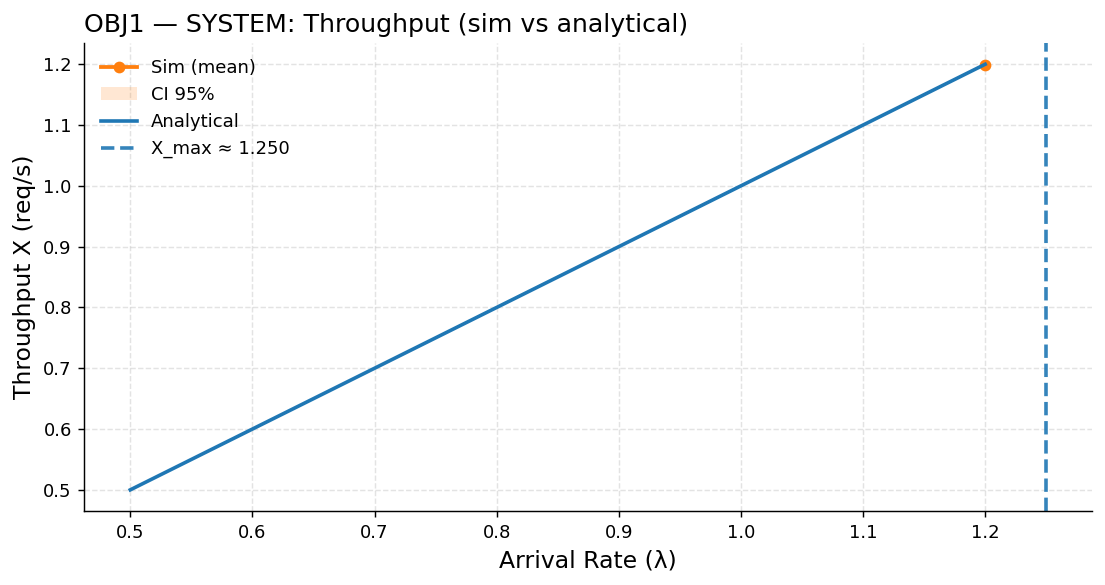

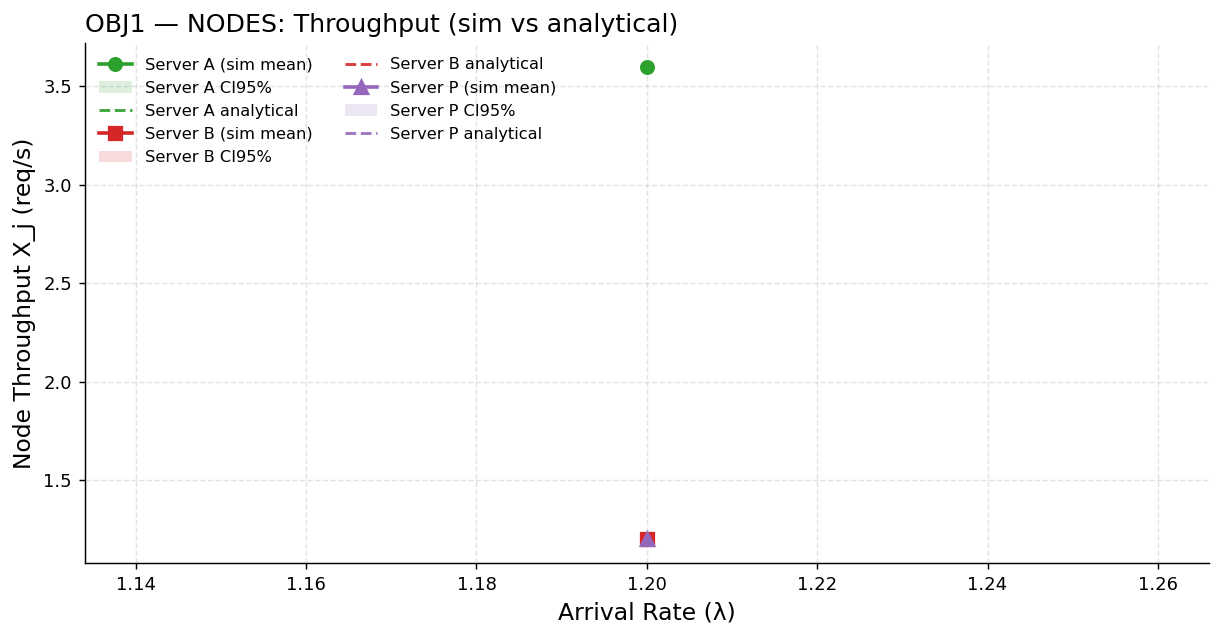

In [20]:
# Confronto throughput complessivo
# analytic_df ottenuto dal tuo CSV analitico completo
plot_system_throughput(df_all, analytic_df, clip_at_Xsat=False, ci_conf=0.95)



# definisci le visite
visits = {"A": 3, "B": 1, "P": 1}

# chiama la funzione
plot_nodes_throughput(
    df_all=df_all,       # <-- qui ci metti il DataFrame delle simulazioni (quello con scope=NODE_*)
    visits=visits,
    nodes=("A", "B", "P"),   # opzionale: limita a questi nodi, se vuoi
    show_theory=True
)


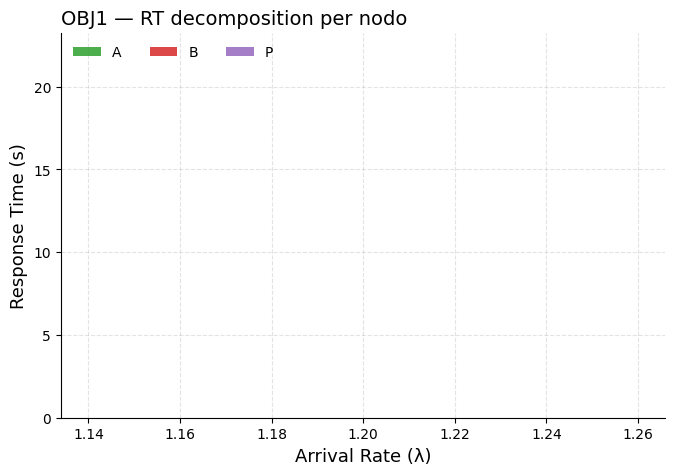

In [21]:
def plot_rt_decomposition(df_all: pd.DataFrame, percent: bool = False):
    """
    Disegna la decomposizione del tempo di risposta per tutti i nodi NODE_* presenti.
    Se percent=True, mostra le percentuali (0–100%) invece dei valori assoluti.
    """
    # filtra righe dei nodi
    dn = df_all[df_all["scope"].astype(str).str.startswith("NODE_")].copy()
    if dn.empty or "mean_response_time" not in dn.columns:
        print("[INFO] Dati insufficienti per RT decomposition.")
        return

    # media per (λ, nodo)
    dn = dn.groupby(["arrival_rate", "scope"], as_index=False).mean(numeric_only=True)

    # pivot: righe = λ, colonne = NODE_*
    piv = dn.pivot(index="arrival_rate", columns="scope", values="mean_response_time").fillna(0.0)

    # ordina colonne alfabeticamente per nodo (A,B,C,P,...)
    cols = sorted(piv.columns, key=lambda s: s.replace("NODE_", ""))
    piv = piv[cols].sort_index()

    # se percentuale, normalizza per riga
    if percent:
        totals = piv.sum(axis=1).replace(0, np.nan)
        piv = piv.div(totals, axis=0) * 100.0

    # etichette "A","B","C","P",... e colori (se PALETTE è definita)
    labels = [c.replace("NODE_", "") for c in piv.columns]
    colors = []
    for lab in labels:
        try:
            colors.append(PALETTE.get(lab, None))  # usa palette se disponibile
        except NameError:
            colors.append(None)  # fallback: colori default di Matplotlib

    # se nessun colore esplicito, lascia che Matplotlib scelga la palette
    use_colors = None if all(c is None for c in colors) else colors

    fig, ax = plt.subplots(figsize=(7.8, 5.0))
    ax.stackplot(piv.index, *[piv[c].values for c in piv.columns],
                 labels=labels, colors=use_colors, alpha=0.85)
    ax.set_xlabel("Arrival Rate (λ)")
    ax.set_ylabel("Share of Response Time (%)" if percent else "Response Time (s)")
    if percent:
        ax.set_ylim(0, 100)
    ax.set_title(f"{TITLE_PREFIX} — RT decomposition per nodo" + (" (%)" if percent else ""))
    ax.legend(loc="upper left", ncol=min(4, len(labels)))
    ax.grid(True, linestyle="--", alpha=0.35)
    plt.show()
plot_rt_decomposition(df_all)

Sull’asse X hai il tasso di arrivo (λ), cioè quante richieste al secondo entrano nel sistema.

Sull’asse Y hai il tempo medio di risposta complessivo, ma scomposto (empilato) per ciascun nodo.

Le aree colorate mostrano quanto ciascun nodo contribuisce al tempo totale.

Interpretazione della figura:

La parte verde (A) è il tempo medio speso sul server A (front-end). Rimane sempre piccola.

La parte viola (P) è il tempo medio sul provider esterno. È quasi costante e poco rilevante.

La parte rossa (B) è il tempo medio speso sul server B (app + DB). Questa cresce rapidamente con λ e diventa dominante.

In altre parole, la figura ti dice visivamente che:

quando il carico è basso, il tempo totale è distribuito un po’ fra tutti i nodi,

ma già per λ intorno a 0.9–1.0 il server B diventa il collo di bottiglia,

e vicino a λ=1.2 quasi tutto il tempo di risposta è dovuto a B.

È un modo elegante per mostrare chi sta rallentando il sistema: la crescita verticale della parte rossa significa che il collo di bottiglia si concentra lì.

Seeds trovati: [314159265, 673620713, 779946103, 1463093617, 1899032171]


C:\Users\leopo\AppData\Local\Temp\ipykernel_21760\1158184731.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out = df.replace({"-": np.nan}).copy()
C:\Users\leopo\AppData\Local\Temp\ipykernel_21760\1158184731.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out = df.replace({"-": np.nan}).copy()
C:\Users\leopo\AppData\Local\Temp\ipykernel_21760\1158184731.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_

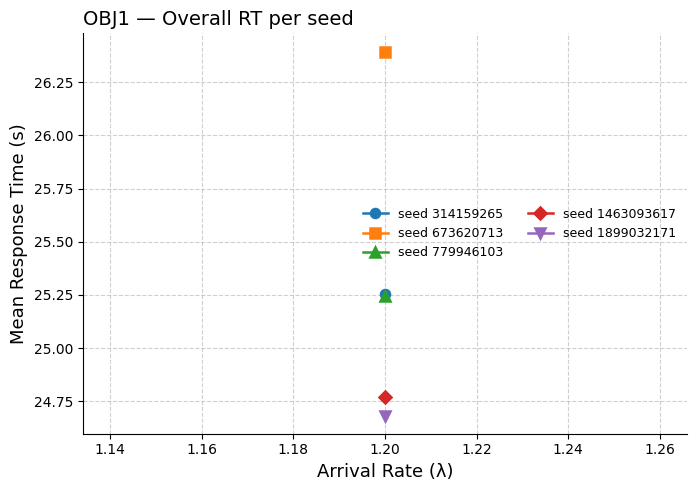

In [22]:

# --- pattern dinamici in base a OBJ e BASE_DIR ---
def make_patterns(obj: int, base_dir: str) -> list[str]:
    """
    Genera una lista di pattern possibili per i CSV per-seed.
    Tenta varianti con/senza 'arrivals' e diverse separazioni per safety.
    """
    base_dir = base_dir.rstrip("/\\")
    patterns = [
        os.path.join(base_dir, f"results_obj{obj}_arrivals_run*_seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_run*_seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_arrivals_*seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_*seed*.csv"),
    ]
    return patterns

# regex seed più permissivo: _seed42, -seed=42, _seed-42, ecc.
_SEED_RE = re.compile(r"[ _-]seed[=_-]?(\d+)", re.IGNORECASE)

def _coerce_numeric(df: pd.DataFrame, exclude=("scope",)):
    """Converte in numerico tutte le colonne tranne quelle escluse; '-' -> NaN."""
    out = df.replace({"-": np.nan}).copy()
    for c in out.columns:
        if c not in exclude:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _seed_from_name(path: str) -> int | None:
    m = _SEED_RE.search(os.path.basename(path))
    return int(m.group(1)) if m else None

def load_arrivals_by_seed(patterns: Iterable[str]) -> pd.DataFrame:
    """
    Carica tutti i CSV che matchano uno QUALSIASI dei pattern,
    aggiunge colonne source/replica/seed. Se non trova nulla, stampa i pattern provati.
    """
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    files = sorted(set(files))  # dedup
    if not files:
        print("[WARN] Nessun CSV trovato per i pattern seguenti:")
        for p in patterns:
            print(" -", p)
        # opzionale: lista rapida della cartella
        base_dirs = sorted(set(os.path.dirname(p) for p in patterns))
        for d in base_dirs:
            try:
                print(f"\nContenuto di {d}:")
                for name in sorted(os.listdir(d)):
                    if name.endswith(".csv"):
                        print("   ", name)
            except FileNotFoundError:
                print(f"(Cartella inesistente: {d})")
        raise FileNotFoundError("Nessun CSV per-seed trovato.")
    dfs = []
    for i, f in enumerate(files):
        df = pd.read_csv(f)
        df = _coerce_numeric(df)  # numerico ovunque possibile
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        df["seed"]    = _seed_from_name(f)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def per_seed_overall(df_all: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    """{seed -> DF OVERALL (una riga per λ, media se più righe)}"""
    df_ov = df_all[df_all["scope"] == "OVERALL"].copy()
    out = {}
    for seed, g in df_ov.groupby("seed"):
        gg = g.groupby("arrival_rate", as_index=False).mean(numeric_only=True)
        gg = gg.sort_values("arrival_rate").reset_index(drop=True)
        out[int(seed) if pd.notna(seed) else -1] = gg
    return out

def per_seed_nodes(df_all: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    """{seed -> DF nodi} una riga per (λ, scope)"""
    dn = df_all.copy()
    dn["scope"] = dn["scope"].astype(str)  # safety contro NaN
    dn = dn[dn["scope"].str.startswith("NODE_")]
    out = {}
    for seed, g in dn.groupby("seed"):
        gg = g.groupby(["arrival_rate", "scope"], as_index=False).mean(numeric_only=True)
        gg = gg.sort_values(["arrival_rate", "scope"]).reset_index(drop=True)
        out[int(seed) if pd.notna(seed) else -1] = gg
    return out

# ----------------------------- plotting --------------------------------

from typing import Iterable, Dict
import matplotlib.pyplot as plt

def plot_overall_rt_per_seed(seed_to_df: Dict[int, pd.DataFrame],
                             title=None, ylabel="Mean Response Time (s)"):
    """Curve OVERALL per ogni seed, con marker dinamici e colori consistenti."""
    fig, ax = plt.subplots(figsize=(7.8, 5.2))

    for i, (seed, df) in enumerate(sorted(seed_to_df.items())):
        if {"arrival_rate", "mean_response_time"}.issubset(df.columns):
            color = f"C{i % 10}"                     # colori dal ciclo default di Matplotlib
            ms = marker_style_for(i, color)          # <-- marker dinamico
            ax.plot(df["arrival_rate"], df["mean_response_time"],
                    color=color, linewidth=1.8, label=f"seed {seed}", **ms)

    ax.set_xlabel("Arrival Rate (λ)")
    ax.set_ylabel(ylabel)
    ax.set_title(title or f"{TITLE_PREFIX} — Overall RT per seed")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(ncol=2, fontsize=9)
    plt.show()


def plot_node_rt_per_seed(seed_to_nodes: Dict[int, pd.DataFrame], title=None):
    """
    Curve per nodo (A/B/P/...) per ciascun seed, con marker dinamici:
    - stessa forma/riempimento per lo *stesso nodo* in tutti i seed;
    - colori: PALETTE per i nodi noti, fallback alla palette di Matplotlib.
    """
    # ordine stabile dei NODE_* presente in tutti i DF
    all_scopes = []
    for df in seed_to_nodes.values():
        if "scope" in df.columns:
            all_scopes.extend(df["scope"].dropna().astype(str).unique().tolist())
    scopes_sorted = sorted({s for s in all_scopes if s.startswith("NODE_")})
    scope_index  = {scope: idx for idx, scope in enumerate(scopes_sorted)}

    fig, ax = plt.subplots(figsize=(8.6, 5.2))

    for seed, df in sorted(seed_to_nodes.items()):
        for scope, g in df.groupby("scope"):
            if not {"arrival_rate", "mean_response_time"}.issubset(g.columns):
                continue
            node = scope.replace("NODE_", "")
            idx  = scope_index.get(scope, 0)
            color = PALETTE.get(node, f"C{idx % 10}")   # colore coerente per nodo
            ms = marker_style_for(idx, color)           # <-- marker dinamico per nodo
            label = f"{node} — seed {seed}"
            ax.plot(g["arrival_rate"], g["mean_response_time"],
                    color=color, linewidth=1.6, label=label, **ms)

    ax.set_xlabel("Arrival Rate (λ)")
    ax.set_ylabel("Mean Response Time (s)")
    ax.set_title(title or f"{TITLE_PREFIX} — Per-node RT per seed")
    ax.grid(True, linestyle="--", alpha=0.6)

    # legenda deduplicata (quando ci sono molte linee)
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), ncol=2, fontsize=8)

    plt.show()

def plot_overall_rt_mean_ci_across_seeds(seed_to_df: Dict[int, pd.DataFrame], title=None):
    """Media cross-seed con CI95% riusando line_with_ci."""
    frames = []
    for seed, df in seed_to_df.items():
        if {"arrival_rate", "mean_response_time"}.issubset(df.columns):
            frames.append(df[["arrival_rate", "mean_response_time"]])
    if not frames:
        print("[INFO] Nessun dato OVERALL per costruire la media cross-seed.")
        return
    big = pd.concat(frames, ignore_index=True)
    line_with_ci(
        big, x="arrival_rate", y="mean_response_time",
        title=title or f"{TITLE_PREFIX} — Overall RT (mean ± CI95%) across seeds",
        xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)"
    )

# --------- ESEMPIO DI USO ---------
patterns = make_patterns(OBJ, BASE_DIR)
df_all = load_arrivals_by_seed(patterns)
print("Seeds trovati:", sorted(df_all["seed"].dropna().unique().astype(int).tolist()))

by_seed_overall = per_seed_overall(df_all)
plot_overall_rt_per_seed(by_seed_overall)

by_seed_nodes = per_seed_nodes(df_all)
# plot_node_rt_per_seed(by_seed_nodes)  # scommenta se vuoi anche per nodo



File conv:
 - .output_simulation\conv_obj1_run000_seed314159265_20250827_190728.csv
 - .output_simulation\conv_obj1_run001_seed1899032171_20250827_190733.csv
 - .output_simulation\conv_obj1_run002_seed1463093617_20250827_190737.csv
 - .output_simulation\conv_obj1_run003_seed779946103_20250827_190741.csv
 - .output_simulation\conv_obj1_run004_seed673620713_20250827_190745.csv
Seeds trovati: [314159265, 673620713, 779946103, 1463093617, 1899032171]


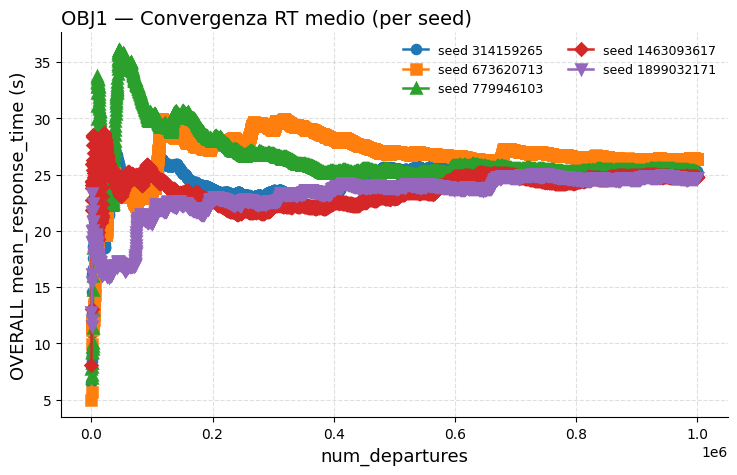

In [23]:
def _lambda_col(df: pd.DataFrame) -> str | None:
    """Trova la colonna dell'arrival rate (robusto a maiuscole/alias)."""
    low = {c.lower().strip(): c for c in df.columns}
    for k in ("arrival_rate", "lambda", "lam"):
        if k in low:
            return low[k]
    return None


# --- loader: lista di DF (uno per file), con seed e source ---
def load_conv_as_list(files: List[str]) -> List[pd.DataFrame]:
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # numeric coercion, ma NON toccare scope/metric
        df = _coerce_numeric(df, exclude=("scope", "metric"))
        df["seed"] = _seed_from_name(f)
        df["source"] = os.path.basename(f)
        dfs.append(df)
    return dfs  # <- LISTA di DataFrame (uno per file)

# --- estrai OVERALL/mean_response_time per seed (dict seed -> DF ordinato per num_departures) ---
def overall_mean_rt_by_seed(dfs: List[pd.DataFrame],
                            arrival_rate: float | None = None,
                            atol: float = 1e-9) -> Dict[int, pd.DataFrame]:
    """
    Ritorna {seed -> DF[num_departures, mean_response_time]}.
    Se arrival_rate è dato, tiene solo le righe con quel λ (tolleranza 'atol').
    """
    out: Dict[int, pd.DataFrame] = {}
    for df in dfs:
        d = df.copy()

        # filtro per λ se richiesto
        lam_col = _lambda_col(d)
        if arrival_rate is not None and lam_col is not None:
            d[lam_col] = pd.to_numeric(d[lam_col], errors="coerce")
            keep = np.isclose(d[lam_col].to_numpy(float), float(arrival_rate),
                              rtol=0.0, atol=atol)
            d = d[keep]

        seed = int(d["seed"].iloc[0]) if "seed" in d.columns and not d.empty else -1
        g = d[(d["scope"] == "OVERALL") & (d["metric"] == "mean_response_time")].copy()
        if g.empty:
            continue
        g = g.sort_values("num_departures")
        out[seed] = g[["num_departures", "value"]].rename(
            columns={"value": "mean_response_time"}
        )

    return out


# --- plot: tutte le curve su un grafico (opzione smoothing con media mobile) ---
def plot_overall_conv_by_seed(seed_to_df: Dict[int, pd.DataFrame],
                              title=None,
                              window_ma: int | None = None,
                              marker_size: float = 0.2,
                              mark_every: int | None = 2000,
                              markers: bool = True,
                              linewidth: float = 0.2):
    fig, ax = plt.subplots(figsize=(8.6, 5.0))
    for i, (seed, g) in enumerate(sorted(seed_to_df.items())):
        color = f"C{i % 10}"
        ms = marker_style_for(i, color)  # hai già definito marker_style_for
        x = g["num_departures"].to_numpy()
        y = g["mean_response_time"].to_numpy(dtype=float)
        if window_ma and window_ma > 1:
            y = pd.Series(y).rolling(window_ma, min_periods=1).mean().to_numpy()
        ax.plot(x, y, linewidth=1.8, color=color, label=f"seed {seed}", **ms)
    ax.set_xlabel("num_departures")
    ax.set_ylabel("OVERALL mean_response_time (s)")
    ax.set_title(title or f"{TITLE_PREFIX} — Convergenza RT medio (per seed)")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(ncol=2, fontsize=9)
    plt.show()

# --- plot: una figura per seed (comodo se vuoi guardarli separati) ---
def plot_overall_conv_one_per_seed(seed_to_df: Dict[int, pd.DataFrame], window_ma: int | None = None):
    for i, (seed, g) in enumerate(sorted(seed_to_df.items())):
        plot_overall_conv_by_seed({seed:g},
                                  title=f"{TITLE_PREFIX} — OVERALL mean RT (seed {seed})",
                                  window_ma=window_ma)

# ====== USO ======

# 1) prendi i file conv (usa la tua utility già esistente)
conv_files = find_csv_for_config(config_file, target="conv")
print("File conv:", *conv_files, sep="\n - ")

# 2) lista di DataFrame, uno per file
dfs_conv = load_conv_as_list(conv_files)   # <<< LISTA richiesta

# 3) dict {seed -> DF OVERALL mean RT vs num_departures}
by_seed = overall_mean_rt_by_seed(dfs_conv, arrival_rate=1.2)



print("Seeds trovati:", sorted(by_seed.keys()))

# 4a) grafico unico con tutte le curve (metti window_ma=5000 se vuoi smoothing visivo)
plot_overall_conv_by_seed(by_seed, window_ma=None)

# 4b) (opzionale) un grafico per seed
# plot_overall_conv_one_per_seed(by_seed, window_ma=10000)


In [24]:

def _pretty_scope(s: str) -> str:
    s = str(s)
    if s == "OVERALL":
        return "OVERALL"
    if s.startswith("NODE_"):
        return f"Server {s.replace('NODE_', '')}"
    return s

def _scope_order(scopes):
    scopes = [str(s) for s in scopes]
    over = ["OVERALL"] if "OVERALL" in scopes else []
    nodes = sorted([s for s in scopes if s != "OVERALL"],
                   key=lambda x: (not x.startswith("NODE_"), x))
    return over + nodes

def _normalize_scopes(names):
    """Permette di passare 'A' o 'NODE_A' indistintamente."""
    out = []
    for n in names:
        s = str(n)
        if s == "OVERALL":
            out.append("OVERALL")
        elif s.startswith("NODE_"):
            out.append(s)
        else:
            out.append(f"NODE_{s}")
    return out



def plot_metric_vertical_by_scope(
    df: pd.DataFrame,
    metric: str,
    *,
    scopes: list[str] | None = None,    # se None: tutti
    hue: str | None = "seed",
    height: float = 2.4,
    aspect: float = 3.2,
    markers: bool = True,
    linewidth: float = 1.2,
    alpha: float = 0.95,
    palette: str | list | None = "tab10",
    xmax: float | None = None,
    xlimit_scopes: list[str] | None = None,
    arrival_rate: float | list[float] | tuple[float, ...] | None = None,  # << NEW
    atol: float = 1e-9,                                                    # << NEW
):
    """
    Subplot verticale (una riga per scope) della metrica scelta.
    Se 'arrival_rate' è impostato, filtra i dati su quel λ (o su una lista di λ).
    """
    d = df.copy()

    # --- filtro λ, se richiesto ---
    lam_col = _lambda_col(d)
    if arrival_rate is not None and lam_col is not None:
        d[lam_col] = pd.to_numeric(d[lam_col], errors="coerce")
        lam = d[lam_col].to_numpy(float)
        if np.isscalar(arrival_rate):
            keep = np.isclose(lam, float(arrival_rate), rtol=0.0, atol=atol)
        else:
            arr = np.asarray(list(arrival_rate), dtype=float)
            keep = np.any(np.isclose(lam[:, None], arr[None, :], rtol=0.0, atol=atol), axis=1)
        d = d[keep]

    # --- filtro metrica ---
    d = d[d["metric"] == metric].copy()
    if d.empty:
        print(f"[WARN] nessun dato per metric='{metric}' (dopo eventuale filtro λ).")
        return

    # --- filtro scope ---
    all_scopes = d["scope"].dropna().unique().tolist()
    row_order = _scope_order(all_scopes) if scopes is None else _scope_order(scopes)
    d = d[d["scope"].isin(row_order)]
    if d.empty:
        print("[WARN] nessun dato dopo il filtro scope.")
        return

    # --- limite X coerente tra subplot ---
    if xmax is None:
        if xlimit_scopes:
            ref_scopes = set(_normalize_scopes(xlimit_scopes))
        else:
            nonA = [s for s in row_order if s != "NODE_A"]
            ref_scopes = set(nonA) if ("NODE_A" in row_order and nonA) else set(row_order)
        xmax = float(d[d["scope"].isin(ref_scopes)]["num_departures"].max())
    xmin = float(d["num_departures"].min())

    # --- plot ---
    sns.set_theme(style="whitegrid", context="notebook")
    use_hue = hue if (hue is not None and hue in d.columns) else None

    g = sns.relplot(
        data=d, kind="line",
        x="num_departures", y="value",
        row="scope", row_order=row_order,
        hue=use_hue, palette=palette,
        markers=markers, dashes=False,
        linewidth=linewidth, alpha=alpha,
        facet_kws=dict(sharex=True, sharey=False, margin_titles=False),
        height=height, aspect=aspect,
        estimator=None, errorbar=None, sort=True,
    )

    for ax, scope in zip(g.axes.flat, row_order):
        ax.set_title(_pretty_scope(scope))
        ax.set_xlabel("num_departures")
        ax.set_ylabel(metric)
        ax.set_xlim(xmin, xmax)
        ax.grid(True, linestyle="--", alpha=0.35)

    add = ""
    if arrival_rate is not None:
        add = f" — λ={arrival_rate}" if np.isscalar(arrival_rate) else f" — λ∈{list(arrival_rate)}"
    g.figure.suptitle(f"{TITLE_PREFIX} — Convergenza per scope — metrica: {metric}{add}",
                      y=1.02, fontsize=14, weight="bold")

    if use_hue is not None and g._legend is not None:
        g._legend.set_title(use_hue)

    plt.tight_layout()
    plt.show()



In [25]:


def _stack_conv_frames(frames: list[pd.DataFrame],
                       seeds: list[int] | None = None) -> pd.DataFrame:
    # includo anche la colonna di λ se esiste
    lam_name = None
    for df in frames:
        if lam_name is None:
            lam_name = _lambda_col(df)

    kept_cols = ["scope", "metric", "value", "num_departures", "seed", "source"]
    if lam_name and lam_name not in kept_cols:
        kept_cols.append(lam_name)

    buf = []
    for i, df in enumerate(frames):
        d = df.copy()
        d = _coerce_numeric(d, exclude=("scope", "metric"))
        if "seed" not in d.columns or d["seed"].isna().all():
            cand = None
            if "source" in d.columns and isinstance(d["source"].iloc[0], str):
                cand = _seed_from_name(d["source"].iloc[0])
            d["seed"] = cand if cand is not None else i
        d = d[[c for c in kept_cols if c in d.columns]]
        buf.append(d)

    big = pd.concat(buf, ignore_index=True)
    if seeds is not None:
        big = big[big["seed"].isin(seeds)]
    return big

def plot_metric_vertical_by_scope_from_list(
    dfs: List[pd.DataFrame],
    metric: str,
    *,
    scopes: list[str] | None = None,
    seeds: list[int] | None = None,
    hue: str | None = "seed",
    height: float = 2.4,
    aspect: float = 3.2,
    markers: bool = True,
    linewidth: float = 1.2,
    alpha: float = 0.95,
    palette: str | list | None = "tab10",
    xmax: float | None = None,
    xlimit_scopes: list[str] | None = None,
    arrival_rate: float | list[float] | tuple[float, ...] | None = None,  # << NEW
    atol: float = 1e-9,                                                    # << NEW
):
    """Versione che accetta una LISTA di DF (uno per seed/file)."""
    d = _stack_conv_frames(dfs, seeds=seeds)
    return plot_metric_vertical_by_scope(
        d, metric,
        scopes=scopes,
        hue=hue,
        height=height,
        aspect=aspect,
        markers=markers,
        linewidth=linewidth,
        alpha=alpha,
        palette=palette,
        xmax=xmax,
        xlimit_scopes=xlimit_scopes,
        arrival_rate=arrival_rate,   # pass-through
        atol=atol,
    )



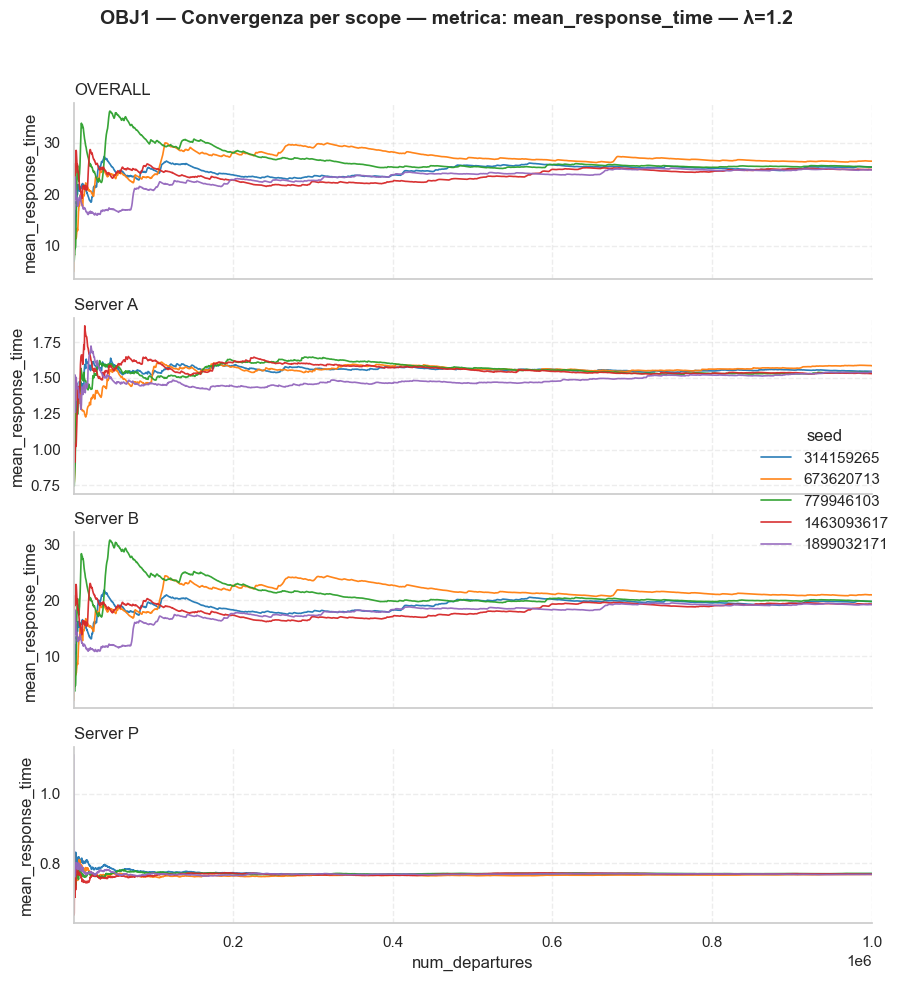

In [26]:


# 2) li carico come LISTA di DF (uno per file/seed)
dfs_conv = load_conv_as_list(conv_files)
"""
plot_metric_vertical_by_scope_from_list(
    dfs_conv, "mean_response_time",
    xlimit_scopes=["OVERALL", "B", "P"]   # 'B' == 'NODE_B', normalizzato
)
"""


# 1) λ singolo
plot_metric_vertical_by_scope_from_list(
    dfs_conv, "mean_response_time",
    arrival_rate=1.2,
    xlimit_scopes=["OVERALL","B","P"]
)


In [27]:
df_all

,scope,arrival_rate,mean_response_time,std_response_time,mean_population,std_population,throughput,utilization,std_response_time_cov,std_population_cov,routing_mode,path_ab,path_abapa,path_abab_forced,source,replica,seed
0,OVERALL,1.2,25.253753,33.800631,29.930478,24.870553,1.200068,0.996629,33.800631,40.563046,NaN,NaN,NaN,NaN,results_obj1_run000_seed314159265_20250827_190...,0,314159265
1,NODE_A,1.2,1.569091,2.984811,5.273312,5.725858,3.600203,0.840417,NaN,NaN,NaN,NaN,NaN,NaN,results_obj1_run000_seed314159265_20250827_190...,0,314159265
2,NODE_B,1.2,19.776062,33.399383,23.732613,24.214833,1.200068,0.959734,NaN,NaN,NaN,NaN,NaN,NaN,results_obj1_run000_seed314159265_20250827_190...,0,314159265
3,NODE_P,1.2,0.770417,0.978743,0.924553,1.333108,1.200068,0.480418,NaN,NaN,NaN,NaN,NaN,NaN,results_obj1_run000_seed314159265_20250827_190...,0,314159265
4,OVERALL,1.2,24.682820,32.758670,29.202589,24.342360,1.198162,0.996498,32.758670,39.250180,NaN,NaN,NaN,NaN,results_obj1_run001_seed1899032171_20250827_19...,1,1899032171
5,NODE_A,1.2,1.568417,3.016002,5.266234,5.792615,3.594485,0.839955,NaN,NaN,NaN,NaN,NaN,NaN,results_obj1_run001_seed1899032171_20250827_19...,1,1899032171
6,NODE_B,1.2,19.209244,32.272276,23.015779,23.524136,1.198162,0.958562,NaN,NaN,NaN,NaN,NaN,NaN,results_obj1_run001_seed1899032171_20250827_19...,1,1899032171
7,NODE_P,1.2,0.768324,0.982478,0.920576,1.334057,1.198162,0.479150,NaN,NaN,NaN,NaN,NaN,NaN,results_obj1_run001_seed1899032171_20250827_19...,1,1899032171
8,OVERALL,1.2,24.771942,32.049045,29.309915,23.422470,1.198493,0.996507,32.049045,38.410565,NaN,NaN,NaN,NaN,results_obj1_run002_seed1463093617_20250827_19...,2,1463093617
9,NODE_A,1.2,1.560152,2.995231,5.230406,5.733837,3.595480,0.839561,NaN,NaN,NaN,NaN,NaN,NaN,results_obj1_run002_seed1463093617_20250827_19...,2,1463093617


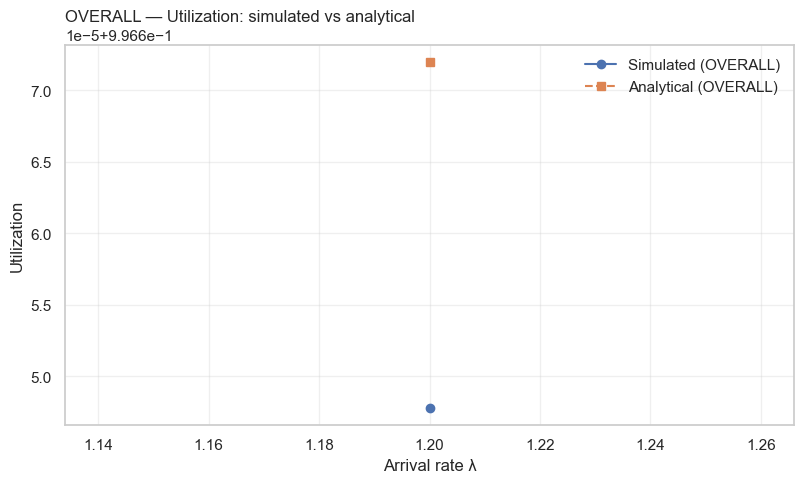

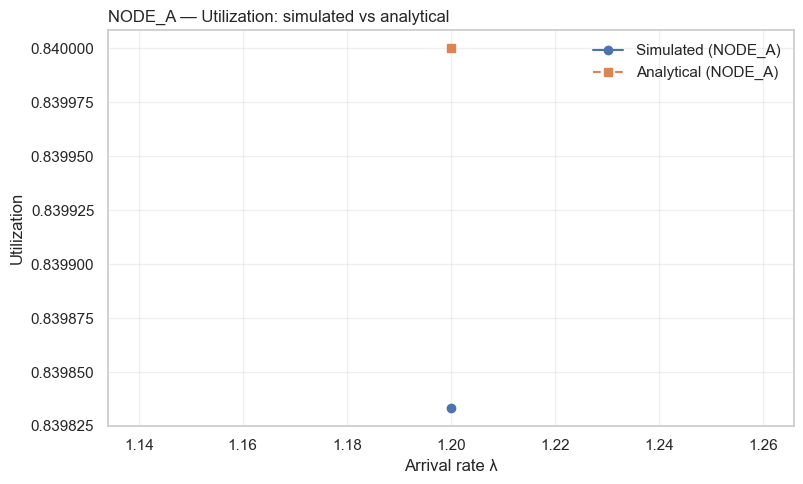

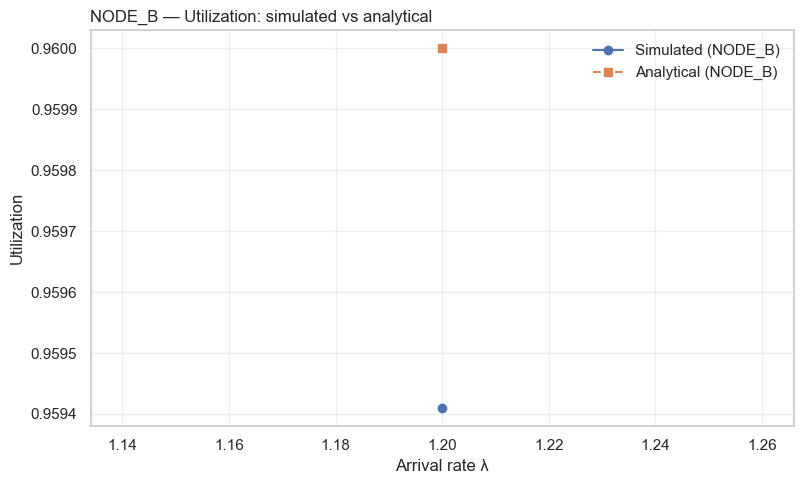

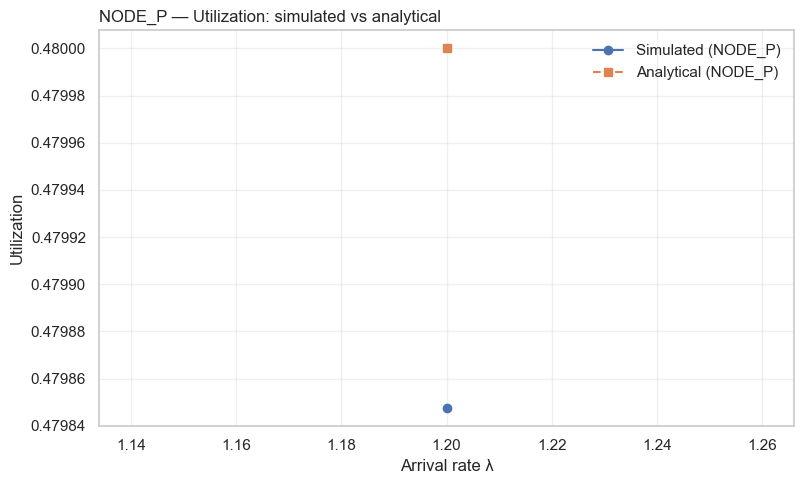

In [28]:
# ===========================================
# Utilizzazione (simulata vs analitica da CSV)
# Richiede: 
#   - df_all  già caricato (load_runs(files))
#   - analytic_df già caricato (tutto l'analitico dal CSV)
# ===========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- check precondizioni
if "df_all" not in globals():
    raise RuntimeError("df_all deve essere già definito (usa le tue find_csv_for_config/load_runs).")
if "analytic_df" not in globals():
    raise RuntimeError("analytic_df deve essere già definito (usa load_analytic_models_for_config o read_csv).")

# Normalizza scope
dfu = df_all.copy()
dfu["scope"] = dfu["scope"].astype(str).str.strip().str.upper()

# Media per (scope, λ) in caso di repliche multiple
agg = (
    dfu.groupby(["scope", "arrival_rate"], as_index=False)
       .agg({"utilization": "mean", "throughput": "mean"})
)

# Nodi presenti nei dati (tutto ciò che non è OVERALL)
nodes = sorted([s for s in agg["scope"].unique() if s != "OVERALL"])
if not nodes:
    nodes = ["NODE_A", "NODE_B", "NODE_P"]  # fallback per layout

# --- prepara analitico: colonne canonicali
amodel = analytic_df.copy()
if "lambda" in amodel.columns and "arrival_rate" not in amodel.columns:
    amodel = amodel.rename(columns={"lambda": "arrival_rate"})
# OVERALL dal CSV: usa 'utilization' se presente, altrimenti 'system_busy_prob'
overall_anal_col = "utilization" if "utilization" in amodel.columns else \
                   ("system_busy_prob" if "system_busy_prob" in amodel.columns else None)
if overall_anal_col is None:
    raise ValueError("Nel CSV analitico mi aspetto 'utilization' o 'system_busy_prob' per l'OVERALL.")

# Allinea al dominio di λ comune (evita extrapolazioni)
lam_sim_overall = agg.loc[agg["scope"] == "OVERALL", "arrival_rate"].unique()
lam_analytical  = amodel["arrival_rate"].unique()
lam_common = np.intersect1d(lam_sim_overall, lam_analytical)

# Filtra simulazione e analitico alle λ comuni
agg_common = agg[agg["arrival_rate"].isin(lam_common)].copy()
amodel_common = amodel[amodel["arrival_rate"].isin(lam_common)].copy().sort_values("arrival_rate")

# ======================
# 1) OVERALL: plot
# ======================
overall_sim = (
    agg_common[agg_common["scope"] == "OVERALL"]
    .sort_values("arrival_rate")[["arrival_rate", "utilization"]]
    .rename(columns={"utilization": "util_sim"})
)

overall_th = amodel_common[["arrival_rate", overall_anal_col]].rename(
    columns={overall_anal_col: "util_th"}
)

df_over_plot = overall_sim.merge(overall_th, on="arrival_rate", how="inner")

plt.figure(figsize=(8.2, 5.0))
plt.plot(df_over_plot["arrival_rate"], df_over_plot["util_sim"], "o-", label="Simulated (OVERALL)")
plt.plot(df_over_plot["arrival_rate"], df_over_plot["util_th"],  "s--", label="Analytical (OVERALL)")
plt.xlabel("Arrival rate λ"); plt.ylabel("Utilization")
plt.title("OVERALL — Utilization: simulated vs analytical")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# ======================
# 2) Per-nodo: plot
# ======================
# Mappa i nomi dei nodi: "NODE_A" -> colonna analitica "util_A"
def _node_key(scope_name: str) -> str:
    return scope_name.replace("NODE_", "").strip()

for scope in nodes:
    node_key = _node_key(scope)
    anal_col = f"util_{node_key}"
    if anal_col not in amodel_common.columns:
        # se manca nel CSV, salta il nodo con un avviso soft
        print(f"[WARN] Colonna analitica '{anal_col}' non trovata. Salto {scope}.")
        continue

    sim_n = (
        agg_common[agg_common["scope"] == scope]
        .sort_values("arrival_rate")[["arrival_rate", "utilization"]]
        .rename(columns={"utilization": "util_sim"})
    )
    th_n = amodel_common[["arrival_rate", anal_col]].rename(columns={anal_col: "util_th"})
    df_n = sim_n.merge(th_n, on="arrival_rate", how="inner")

    plt.figure(figsize=(8.2, 5.0))
    plt.plot(df_n["arrival_rate"], df_n["util_sim"], "o-", label=f"Simulated ({scope})")
    plt.plot(df_n["arrival_rate"], df_n["util_th"],  "s--", label=f"Analytical ({scope})")
    plt.xlabel("Arrival rate λ"); plt.ylabel("Utilization")
    plt.title(f"{scope} — Utilization: simulated vs analytical")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


In [29]:
# ============================================================
# UTILIZZAZIONE — banda CI (sim) + curva analitica da CSV
# Requisiti: df_all e analytic_df già caricati
#   - OVERALL dal CSV: 'utilization' (o 'system_busy_prob')
#   - Nodi dal CSV:    'util_A', 'util_B', 'util_P', ...
# Riusa _draw_ci_banded / _z_value / _pal già definite
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _util_ci(df_scope: pd.DataFrame, *, conf: float, ci_design_effect: float) -> pd.DataFrame:
    """CI di utilizzo per λ: tra repliche se ci sono; fallback conservativo se c'è 1 sola riga."""
    z = _z_value(conf)
    g = (df_scope.groupby("arrival_rate")
                 .agg(mean=("utilization","mean"),
                      std =("utilization","std"),
                      R   =("replica","nunique"))
                 .reset_index()
                 .sort_values("arrival_rate"))
    g["R"] = g["R"].fillna(1).astype(int)
    half = z * g["std"].to_numpy(float)
    mask = g["R"].to_numpy(int) > 1
    half[mask]  = half[mask]  / np.sqrt(g.loc[mask, "R"].to_numpy(float))
    half[~mask] = half[~mask] * np.sqrt(float(ci_design_effect))
    g["half"] = np.nan_to_num(half, nan=0.0, posinf=0.0, neginf=0.0)
    return g.rename(columns={"arrival_rate":"x"})

def plot_utilization_banded_csv(df_all: pd.DataFrame,
                                analytic_df: pd.DataFrame,
                                *,
                                conf: float = 0.95,
                                ci_design_effect: float = 12.0,
                                ci_fill: bool = True,
                                min_display_half: float = 0.0,
                                node_order: list[str] | None = None,
                                cols: int = 2,
                                figsize=(12, 9),
                                savepath: str | None = None,
                                title: str = "Confidence interval for utilization (sim vs analytical)"):
    if df_all is None or df_all.empty:
        raise ValueError("df_all è vuoto o mancante.")
    if analytic_df is None or analytic_df.empty:
        raise ValueError("analytic_df è vuoto o mancante.")

    # --- normalizza
    dfu = df_all.copy()
    dfu["scope"] = dfu["scope"].astype(str).str.strip().str.upper()

    # --- nodi presenti nei dati
    nodes = sorted([s for s in dfu["scope"].unique() if s != "OVERALL"])
    if node_order:
        nodes = [n for n in node_order if n in nodes] + [n for n in nodes if n not in (node_order or [])]

    # --- CI simulazione
    ci_over  = _util_ci(dfu[dfu["scope"]=="OVERALL"], conf=conf, ci_design_effect=ci_design_effect)
    ci_nodes = {n: _util_ci(dfu[dfu["scope"]==n], conf=conf, ci_design_effect=ci_design_effect) for n in nodes}

    # --- modello analitico dal CSV
    amodel = analytic_df.copy()
    if "lambda" in amodel.columns and "arrival_rate" not in amodel.columns:
        amodel = amodel.rename(columns={"lambda":"arrival_rate"})
    amodel = amodel.sort_values("arrival_rate").reset_index(drop=True)

    # colonne per OVERALL
    over_col = "utilization" if "utilization" in amodel.columns else \
               ("system_busy_prob" if "system_busy_prob" in amodel.columns else None)
    if over_col is None:
        raise ValueError("Nel CSV analitico serve 'utilization' o 'system_busy_prob' per OVERALL.")

    # allinea dominio λ: usa solo le λ comuni tra sim e analitico per evitare extrapolazioni
    lam_sim = np.sort(ci_over["x"].to_numpy(float))
    lam_csv = np.sort(amodel["arrival_rate"].to_numpy(float))
    lam_common = np.intersect1d(lam_sim, lam_csv)
    amodel = amodel[amodel["arrival_rate"].isin(lam_common)].copy()
    ci_over  = ci_over [ci_over ["x"].isin(lam_common)].copy()
    for n in list(ci_nodes.keys()):
        ci_nodes[n] = ci_nodes[n][ci_nodes[n]["x"].isin(lam_common)].copy()

    # --- layout
    import math as _m
    n_panels = 1 + len(nodes)
    rows = _m.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.suptitle(title, y=0.98)

    col_sim = _pal("SIM", "#1f77b4")
    col_the = _pal("THEORY", "#ff7f0e")

    # --- OVERALL
    ax = axs[0]
    _draw_ci_banded(ax,
                    x=ci_over["x"], mean=ci_over["mean"], half=ci_over["half"],
                    color=col_sim,
                    label_line="simulation (mean)",
                    label_band="simulation CI band",
                    label_ci=f"CI {int(conf*100)}%",
                    min_display_half=min_display_half, ci_fill=ci_fill)
    ax.plot(amodel["arrival_rate"], amodel[over_col],
            color=col_the, linewidth=2.2, linestyle="--", marker="s", markersize=4,
            label="analytical model", zorder=6)
    ax.set_title("SYSTEM utilization")
    ax.set_xlabel("Lambda"); ax.set_ylabel("Utilization"); ax.legend()

    # --- NODI
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d  = ci_nodes[n]
        _draw_ci_banded(ax,
                        x=d["x"], mean=d["mean"], half=d["half"],
                        color=col_sim,
                        label_line="simulation (mean)",
                        label_band="simulation CI band",
                        label_ci=f"CI {int(conf*100)}%",
                        min_display_half=min_display_half, ci_fill=ci_fill)

        node_key = n.replace("NODE_", "")
        anal_col = f"util_{node_key}"
        if anal_col in amodel.columns:
            ax.plot(amodel["arrival_rate"], amodel[anal_col],
                    color=col_the, linewidth=2.2, linestyle="--", marker="s", markersize=4,
                    label="analytical model", zorder=6)
        else:
            ax.text(0.02, 0.92, f"[no '{anal_col}' in CSV]", transform=ax.transAxes, fontsize=9,
                    ha="left", va="top", color="#888")

        ax.set_title(f"{n} utilization")
        ax.set_xlabel("Lambda"); ax.set_ylabel("Utilization")
        ax.legend()

    # nascondi assi extra
    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)

    for ax in axs:
        ax.grid(True, linestyle="--", alpha=0.35)
        ax.tick_params(axis='x', which='both', labelbottom=True)

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig


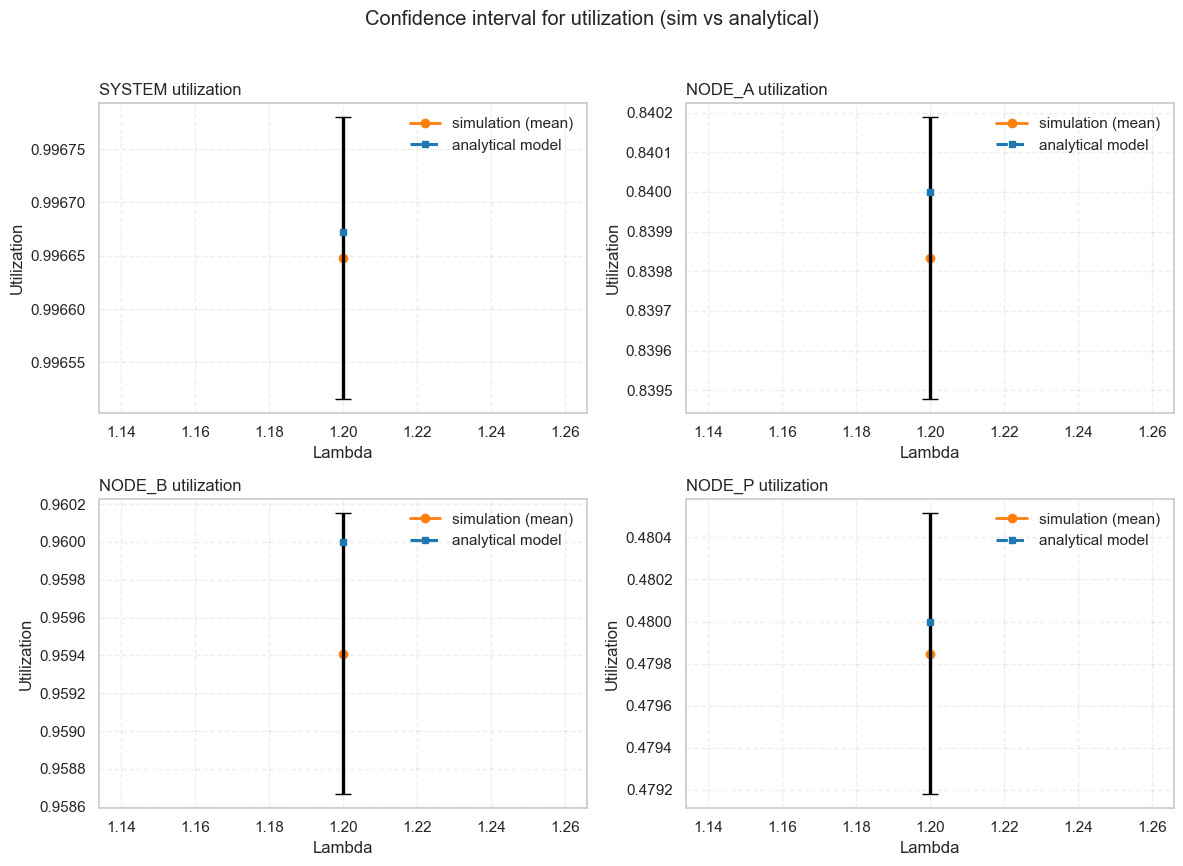

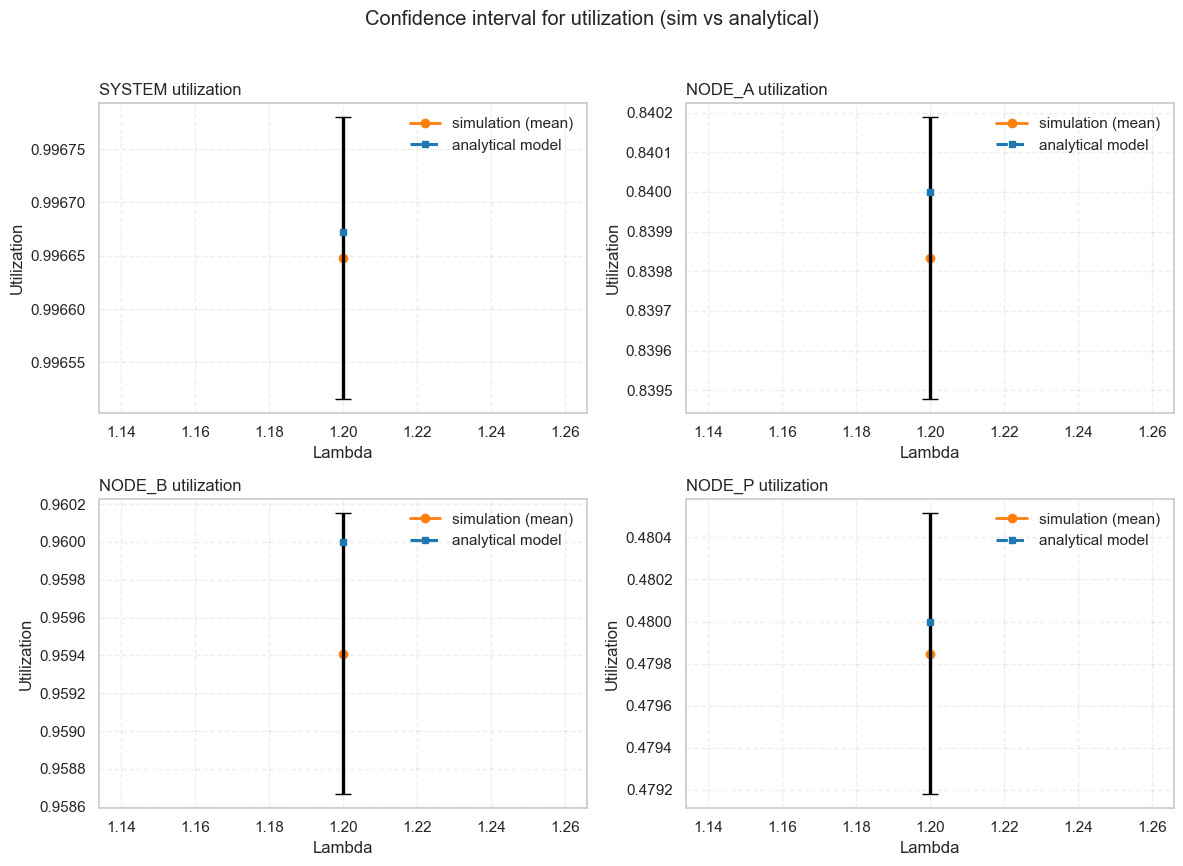

In [30]:
plot_utilization_banded_csv(
    df_all,
    analytic_df,
    conf=0.95,
    ci_design_effect=12.0,
    ci_fill=True,
    min_display_half=0.0,
    node_order=["NODE_A","NODE_B","NODE_P"],  # opzionale
    cols=2,
    figsize=(12,9)
)


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Normalizza dfs_conv in un unico DataFrame ---
def _ensure_conv_df(dfs_conv) -> pd.DataFrame:
    """
    Accetta: DataFrame, lista/tupla di DataFrame o path/CSV/dizionari, singolo dict/lista-record.
    Ritorna un unico DataFrame con almeno: scope, metric, value, num_departures (+ opzionale arrival_rate).
    """
    if isinstance(dfs_conv, pd.DataFrame):
        df = dfs_conv.copy()
    elif isinstance(dfs_conv, (list, tuple)):
        parts = []
        for x in dfs_conv:
            if isinstance(x, pd.DataFrame):
                parts.append(x)
            elif isinstance(x, (str, Path)):
                parts.append(pd.read_csv(x))
            elif isinstance(x, dict):
                parts.append(pd.DataFrame([x]))
            else:
                try:
                    parts.append(pd.DataFrame(x))
                except Exception as e:
                    raise TypeError(f"Elemento non supportato in dfs_conv: {type(x)}") from e
        if not parts:
            raise ValueError("dfs_conv è una lista vuota.")
        df = pd.concat(parts, ignore_index=True)
    elif isinstance(dfs_conv, dict):
        df = pd.DataFrame([dfs_conv])
    else:
        df = pd.DataFrame(dfs_conv)

    # colonne minime
    required = {"scope", "metric", "value", "num_departures"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Mancano colonne in dfs_conv: {missing}")

    # forza i tipi numerici dove serve
    for c in ("value", "num_departures"):
        df[c] = pd.to_numeric(df[c], errors="coerce")
    if "arrival_rate" in df.columns:
        df["arrival_rate"] = pd.to_numeric(df["arrival_rate"], errors="coerce")

    # ordina per sicurezza
    return df.sort_values(["scope", "metric", "num_departures"]).reset_index(drop=True)

# --- Costruzione serie temporale per una metrica (es. mean_population) ---
def transient_series_from_conv(dfs_conv,
                               scope: str,
                               metric: str = "mean_population",
                               arrival_rate: float | None = None,
                               downsample_every: int = 1,
                               ewma_span: int | None = 15) -> pd.DataFrame:
    """
    Ricostruisce il tempo t ≈ num_departures / throughput (stesso scope e snapshot),
    e ritorna una serie ordinata con colonne ['t','value','value_smooth'].
    """
    df = _ensure_conv_df(dfs_conv)

    # filtro per λ se presente
    if arrival_rate is not None and "arrival_rate" in df.columns:
        df = df[df["arrival_rate"].eq(arrival_rate)]

    df_metric = df[(df["scope"].eq(scope)) & (df["metric"].eq(metric))][["num_departures", "value"]].copy()
    if df_metric.empty:
        return pd.DataFrame(columns=["t","value","value_smooth"])

    df_thr = df[(df["scope"].eq(scope)) & (df["metric"].eq("throughput"))][["num_departures", "value"]].copy()
    df_thr = df_thr.rename(columns={"value": "throughput"}).sort_values("num_departures")

    # allinea per num_departures (tollerante)
    df_metric = df_metric.sort_values("num_departures")
    series = pd.merge_asof(df_metric, df_thr, on="num_departures", direction="nearest")

    # tempo ricostruito (se manca throughput, prova con arrival_rate se disponibile)
    if "throughput" in series.columns and series["throughput"].notna().any():
        denom = series["throughput"].replace(0, np.nan)
    elif arrival_rate is not None and arrival_rate > 0:
        denom = float(arrival_rate)
    else:
        # non posso ricostruire il tempo
        series["t"] = np.arange(len(series), dtype=float)
        series = series.dropna(subset=["value"]).sort_values("t")[["t", "value"]]
        series["value_smooth"] = (
            series["value"].ewm(span=ewma_span, adjust=False).mean()
            if ewma_span is not None and len(series) > 3 else series["value"]
        )
        return series

    series["t"] = series["num_departures"] / denom
    series = series.dropna(subset=["t"]).sort_values("t")[["t", "value"]]

    # downsampling opzionale
    if downsample_every > 1 and len(series) > downsample_every:
        series = series.iloc[::downsample_every, :].reset_index(drop=True)

    # smoothing (solo per plot)
    if ewma_span is not None and len(series) > 3:
        series["value_smooth"] = series["value"].ewm(span=ewma_span, adjust=False).mean()
    else:
        series["value_smooth"] = series["value"]
    return series

def estimate_convergence(y: np.ndarray, x: np.ndarray, tail_frac: float = 0.2) -> dict:
    """Stima valore limite (media coda) e pendenza sulla coda (retta LS)."""
    n = len(x)
    if n == 0:
        return {"tail_mean": np.nan, "tail_std": np.nan, "slope": np.nan, "n_tail": 0}
    k0 = max(1, int(n * (1.0 - tail_frac)))
    xt, yt = x[k0:], y[k0:]
    A = np.vstack([xt, np.ones_like(xt)]).T
    slope, intercept = np.linalg.lstsq(A, yt, rcond=None)[0]
    return {
        "tail_mean": float(np.mean(yt)),
        "tail_std": float(np.std(yt, ddof=1)) if len(yt) > 1 else 0.0,
        "slope": float(slope),
        "intercept": float(intercept),
        "n_tail": int(len(yt))
    }

from scipy import stats

def plot_transient_population_over_seeds(dfs_conv_list,
                                         scopes=("OVERALL", "NODE_A", "NODE_B", "NODE_P"),
                                         *,
                                         arrival_rate: float,
                                         ewma_span: int | None = 25,
                                         npoints: int = 400,
                                         conf: float = 0.95,
                                         title_prefix="Transient (mean over seeds) — mean_population",
                                         analytic_df: pd.DataFrame | None = None):
    """
    Transitorio medio su più seed: ricostruisce t, interpola, fa media + banda CI tra seed.
    Se analytic_df è fornito, aggiunge il livello teorico (mean_population) per OVERALL.
    """
    # ricava griglia tempo comune
    series_list = []
    for dfs_conv in dfs_conv_list:
        s = transient_series_from_conv(dfs_conv, "OVERALL",
                                       metric="mean_population",
                                       arrival_rate=arrival_rate,
                                       downsample_every=5, ewma_span=ewma_span)
        if not s.empty:
            series_list.append(s)
    if not series_list:
        raise RuntimeError("Nessuna serie disponibile.")

    t_min = max(s["t"].min() for s in series_list)
    t_max = min(s["t"].max() for s in series_list)
    grid_t = np.linspace(t_min, t_max, npoints)

    fig, axes = plt.subplots(2, 2, figsize=(12, 7), squeeze=False)
    axes = axes.ravel()

    for ax, scope in zip(axes, scopes):
        curves = []
        for dfs_conv in dfs_conv_list:
            s = transient_series_from_conv(dfs_conv, scope,
                                           metric="mean_population",
                                           arrival_rate=arrival_rate,
                                           downsample_every=5, ewma_span=ewma_span)
            if s.empty: continue
            y_interp = np.interp(grid_t, s["t"], s["value_smooth"])
            curves.append(y_interp)
        if not curves: 
            ax.set_title(f"{scope}: nessun dato"); ax.axis("off"); continue

        Y = np.vstack(curves)  # shape = (nseed, npoints)
        mu = Y.mean(axis=0)
        se = Y.std(axis=0, ddof=1) / np.sqrt(Y.shape[0])
        z = stats.t.ppf(0.5 + conf/2.0, df=Y.shape[0]-1)
        half = z * se

        ax.plot(grid_t, mu, color="tab:blue", linewidth=2, label="mean over seeds (EWMA)")
        ax.fill_between(grid_t, mu-half, mu+half, color="tab:blue", alpha=0.2,
                        label=f"CI {int(conf*100)}% (between seeds)")

        # overlay valore teorico dal CSV
        if analytic_df is not None and scope == "OVERALL":
            am = analytic_df.copy()
            if "lambda" in am.columns and "arrival_rate" not in am.columns:
                am = am.rename(columns={"lambda": "arrival_rate"})
            row = am.loc[np.isclose(am["arrival_rate"].to_numpy(float), float(arrival_rate), atol=1e-9)]
            if not row.empty and "mean_population" in row.columns:
                theor = float(row["mean_population"].iloc[0])
                ax.axhline(theor, linestyle="--", color="tab:orange", linewidth=2,
                           label=f"analytical (λ={arrival_rate}, N={theor:.3f})")

        ax.set_title(f"{scope} — mean over seeds")
        ax.set_xlabel("Tempo simulazione (s)")
        ax.set_ylabel("Mean population")
        ax.grid(True, alpha=0.3)
        ax.legend()

    fig.suptitle(f"{title_prefix} (λ={arrival_rate})")
    plt.tight_layout()
    plt.show()



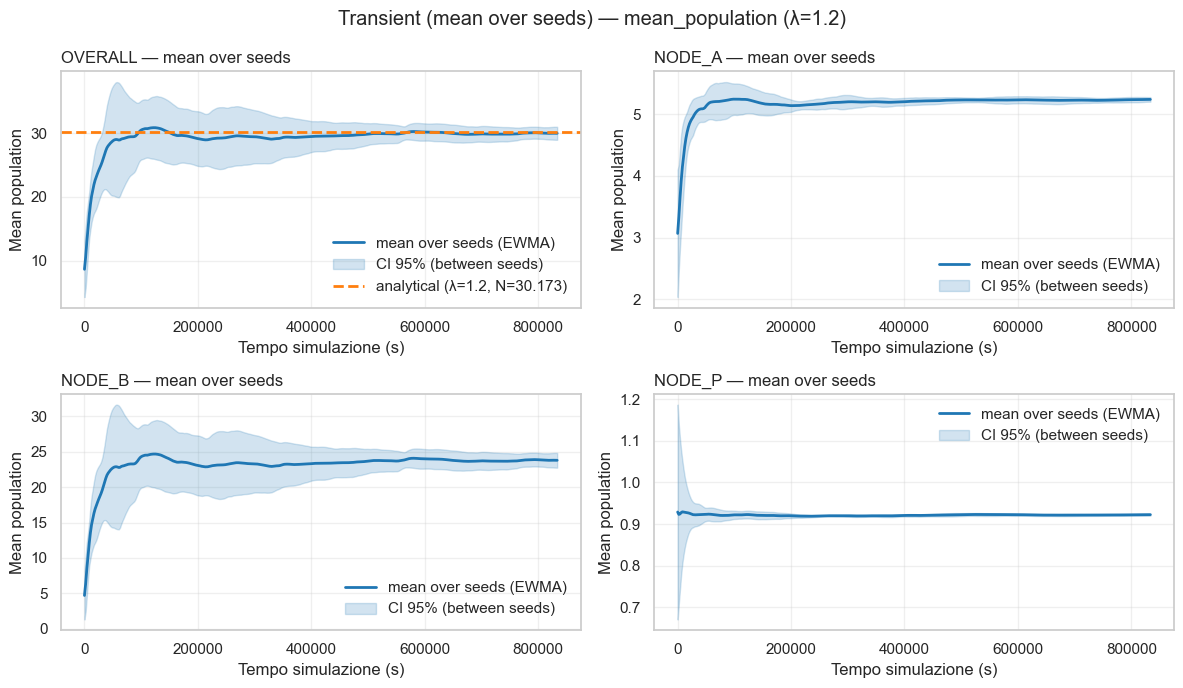

In [32]:
# dfs_conv = load_conv_as_list(conv_files)  # come già fai
# analytic_df = load_analytic_models_for_config(config_path, base_dir=BASE_DIR)  # già definita

plot_transient_population_over_seeds(
    dfs_conv,
    arrival_rate=1.2,        # λ di interesse
    analytic_df=analytic_df  # opzionale, per la linea teorica OVERALL
)



In [39]:
def plot_transient_response_time(dfs_conv,
                                 scopes=("OVERALL", "NODE_A", "NODE_B", "NODE_P"),
                                 *,
                                 arrival_rate: float | None = None,
                                 downsample_every: int = 5,
                                 ewma_span: int | None = 25,
                                 slope_tol: float = 1e-3,
                                 title_prefix: str = "Transient of mean response time"):
    """
    Plotta il transitorio del **tempo di risposta medio** (mean_response_time) per gli scope indicati,
    ricostruendo l'asse X in **secondi** via t ≈ num_departures / throughput.
    Richiede le stesse colonne di dfs_conv: [scope, metric, value, num_departures, (facoltativo) arrival_rate].
    """
    # se c'è più di un λ e non si filtra, prendo il min per evitare di mischiare run diversi
    df_probe = _ensure_conv_df(dfs_conv)
    if arrival_rate is None and "arrival_rate" in df_probe.columns and df_probe["arrival_rate"].nunique() > 1:
        arrival_rate = float(df_probe["arrival_rate"].sort_values().iloc[0])

    nplots = len(scopes)
    nrows = 2 if nplots > 1 else 1
    ncols = int(np.ceil(nplots / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.6*nrows), squeeze=False)
    axes = axes.ravel()

    for ax, scope in zip(axes, scopes):
        # --- costruisce la serie temporale per mean_response_time ---
        series = transient_series_from_conv(
            dfs_conv, scope, metric="mean_response_time",
            arrival_rate=arrival_rate,
            downsample_every=downsample_every, ewma_span=ewma_span
        )
        if series.empty:
            ax.set_title(f"{scope}: nessun dato"); ax.axis("off"); continue

        x = series["t"].to_numpy(float)           # tempo simulazione (s)
        y = series["value"].to_numpy(float)       # misura "grezza"
        ys = series["value_smooth"].to_numpy(float)  # EWMA (lisciata)

        # --- stima della convergenza sulla coda (retta LS) ---
        info = estimate_convergence(ys, x, tail_frac=0.2)
        converges = (np.isfinite(info["slope"]) and abs(info["slope"]) < slope_tol)

        # --- plot ---
        ax.plot(x, y, alpha=0.35, label="misura (raw)")
        ax.plot(x, ys, linewidth=2.0, label="EWMA", zorder=3)
        ax.axhline(info["tail_mean"], linestyle="--",
                   color=("tab:green" if converges else "tab:red"),
                   alpha=0.85, linewidth=1.8,
                   label=("stima limite" if converges else "trend non stazionario"))

        subtitle = f"{scope} — {'converge' if converges else 'non converge'}"
        subtitle += f" (tail≈{info['tail_mean']:.3g}s, slope≈{info['slope']:.2e})"
        ax.set_title(subtitle)
        ax.set_xlabel("Tempo simulazione (s)")
        ax.set_ylabel("Mean response time (s)")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")

    if arrival_rate is not None:
        fig.suptitle(f"{title_prefix} (λ={arrival_rate:g})")
    else:
        fig.suptitle(title_prefix)
    plt.tight_layout()
    plt.show()

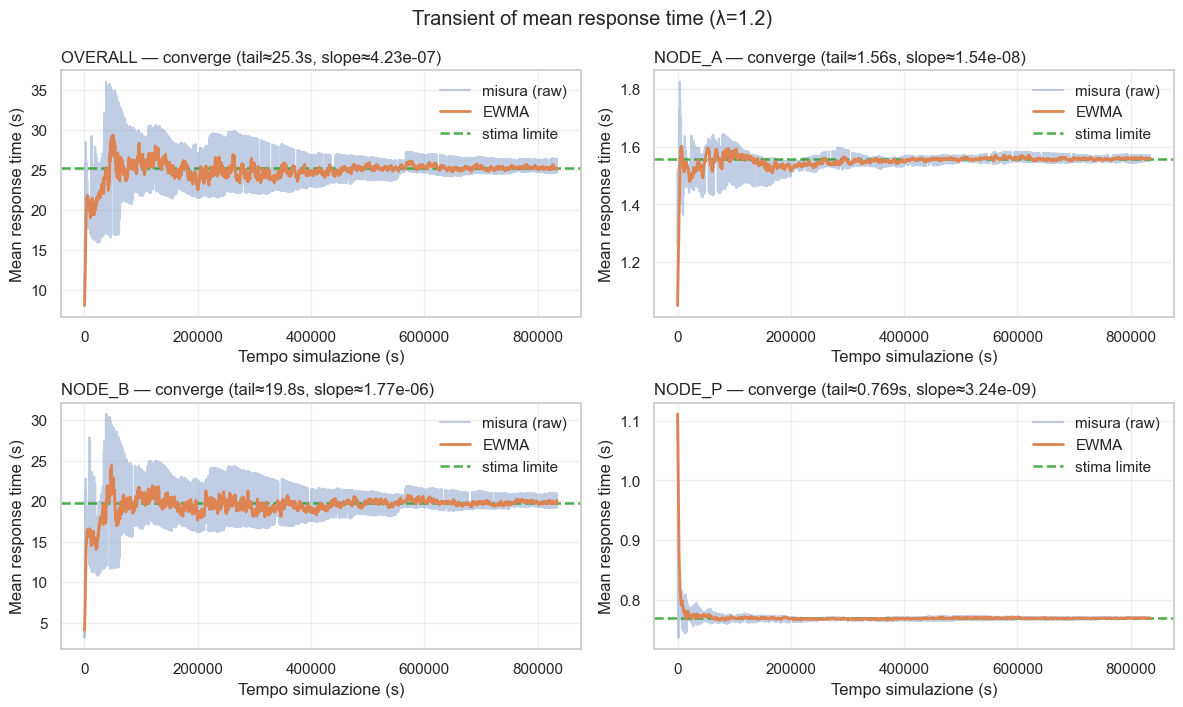

In [40]:
plot_transient_response_time(dfs_conv, arrival_rate=1.2)

In [41]:
# plot_mean_rt_by_seed_single_line.py
# Requisiti: pandas, matplotlib, numpy
# pip install pandas matplotlib

import re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path(".output_simulation")
SMOOTH = True        # True: interpola su griglia fine; False: solo i punti unici (senza marker)
GRID_POINTS = 200    # risoluzione della griglia per l'interpolazione

files = sorted(glob.glob(str(DATA_DIR / "*.csv")))
if not files:
    raise SystemExit(f"Nessun CSV trovato in {DATA_DIR.resolve()}")

seed_re = re.compile(r"seed(\d+)")
prob_re = re.compile(r"prob([0-9\.eE+-]+)")

def parse_seed_prob(fname: str):
    s = seed_re.search(fname)
    p = prob_re.search(fname)
    if not (s and p):
        raise ValueError(f"Impossibile estrarre seed/prob da: {fname}")
    return int(s.group(1)), float(p.group(1))

def extract_mean_rt(df: pd.DataFrame) -> float:
    cols = list(df.columns)
    lcols = [c.lower().strip() for c in cols]
    preferred = "mean_reponse_time"
    for pat in preferred:
        for i, c in enumerate(lcols):
            if re.search(pat, c):
                ser = pd.to_numeric(df[cols[i]], errors="coerce")
                return float(ser.dropna().mean())

    for i, c in enumerate(lcols):
        if any(k in c for k in ["response", "resp_time", "rt", "r_time"]):
            ser = pd.to_numeric(df[cols[i]], errors="coerce")
            if ser.notna().any():
                return float(ser.dropna().mean())

    num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    if len(num_cols) == 1:
        return float(df[num_cols[0]].mean())

    for c in cols:
        ser = pd.to_numeric(df[c], errors="coerce")
        if ser.notna().any():
            return float(ser.dropna().mean())

    raise ValueError("Colonna per Mean Response Time non trovata.")

rows = []
for f in files:
    try:
        seed, prob = parse_seed_prob(Path(f).name)
    except Exception as e:
        print(f"[skip] {f}: {e}"); continue

    try:
        try:
            df = pd.read_csv(f)
        except Exception:
            df = pd.read_csv(f, sep=';')
        mrt = extract_mean_rt(df)
        rows.append((seed, round(prob, 3), mrt))
    except Exception as e:
        print(f"[skip] {f}: {e}")

if not rows:
    raise SystemExit("Nessun dato utile estratto dai CSV.")

data = pd.DataFrame(rows, columns=["seed", "prob", "mean_rt"])

# 1) Collassa repliche allo stesso p: un solo valore medio per seed,p
agg = (data.groupby(["seed", "prob"], as_index=False)["mean_rt"].mean()
            .sort_values(["seed","prob"]))

plt.figure(figsize=(10,5))
for seed, g in agg.groupby("seed"):
    g = g.sort_values("prob")
    x = g["prob"].to_numpy()
    y = g["mean_rt"].to_numpy()

    if SMOOTH and len(x) >= 2:
        # interpola su una griglia fine per una curva unica “liscia”
        x_grid = np.linspace(x.min(), x.max(), GRID_POINTS)
        y_grid = np.interp(x_grid, x, y)
        plt.plot(x_grid, y_grid, linewidth=2, label=f"seed {seed}")
    else:
        # nessun marker, solo linea unica sui p disponibili
        plt.plot(x, y, linewidth=2, label=f"seed {seed}")

plt.xlabel("Probability p")
plt.ylabel("Mean Response Time")
plt.title("Mean Response Time vs p per seed")
plt.grid(True, alpha=0.3)
plt.legend(title="Seeds", ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


# (opzionale) stampa tabellina riassuntiva
summary = (data
           .sort_values(["seed","prob"])
           .pivot_table(index="prob", columns="seed", values="mean_rt", aggfunc="mean"))
print("\nTabella (Mean RT per p, colonne=seed):")
print(summary.to_string(float_format=lambda x: f"{x:.4f}"))





[skip] .output_simulation\analytic_sweep_lambda.csv: Impossibile estrarre seed/prob da: analytic_sweep_lambda.csv
[skip] .output_simulation\conv_obj1_run000_seed314159265_20250827_190728.csv: Impossibile estrarre seed/prob da: conv_obj1_run000_seed314159265_20250827_190728.csv
[skip] .output_simulation\conv_obj1_run001_seed1899032171_20250827_190733.csv: Impossibile estrarre seed/prob da: conv_obj1_run001_seed1899032171_20250827_190733.csv
[skip] .output_simulation\conv_obj1_run002_seed1463093617_20250827_190737.csv: Impossibile estrarre seed/prob da: conv_obj1_run002_seed1463093617_20250827_190737.csv
[skip] .output_simulation\conv_obj1_run003_seed779946103_20250827_190741.csv: Impossibile estrarre seed/prob da: conv_obj1_run003_seed779946103_20250827_190741.csv
[skip] .output_simulation\conv_obj1_run004_seed673620713_20250827_190745.csv: Impossibile estrarre seed/prob da: conv_obj1_run004_seed673620713_20250827_190745.csv
[skip] .output_simulation\per_job_times.csv: Impossibile estra

SystemExit: Nessun dato utile estratto dai CSV.

d:\leopo\Desktop\Leonardo\Uni\PMCNS-PROJECT\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#plot_ci_mean_rt_by_p.py
# Requisiti: pandas, matplotlib, numpy
# pip install pandas matplotlib

import re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path(".output_simulation")
files = sorted(glob.glob(str(DATA_DIR / "*.csv")))
if not files:
    raise SystemExit(f"Nessun CSV trovato in {DATA_DIR.resolve()}")

seed_re = re.compile(r"seed(\d+)")
prob_re = re.compile(r"prob([0-9\.eE+-]+)")

def parse_seed_prob(fname: str):
    s = seed_re.search(fname)
    p = prob_re.search(fname)
    if not (s and p):
        raise ValueError(f"Impossibile estrarre seed/prob da: {fname}")
    return int(s.group(1)), float(p.group(1))

def extract_mean_rt(df: pd.DataFrame) -> float:
    """
    Estrae un 'Mean Response Time' robustamente:
    - prova varie nomenclature comuni
    - altrimenti prova colonne con 'response'/'rt'
    - fallback: prima colonna numerica media
    """
    cols = list(df.columns)
    lcols = [c.lower().strip() for c in cols]
    preferred = "mean_response_time"
    for pat in preferred:
        for i, c in enumerate(lcols):
            if re.search(pat, c):
                ser = pd.to_numeric(df[cols[i]], errors="coerce")
                return float(ser.dropna().mean())

    for i, c in enumerate(lcols):
        if any(k in c for k in ["response", "resp_time", "rt", "r_time"]):
            ser = pd.to_numeric(df[cols[i]], errors="coerce")
            if ser.notna().any():
                return float(ser.dropna().mean())

    num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    if num_cols:
        return float(df[num_cols[0]].mean())

    raise ValueError("Colonna per Mean Response Time non trovata.")

# carica tutti i punti (seed, p) -> mean_rt
rows = []
for f in files:
    try:
        seed, prob = parse_seed_prob(Path(f).name)
    except Exception as e:
        print(f"[skip nome] {f}: {e}")
        continue
    try:
        try:
            df = pd.read_csv(f)
        except Exception:
            df = pd.read_csv(f, sep=';')
        mrt = extract_mean_rt(df)
        rows.append((round(prob, 3), seed, mrt))
    except Exception as e:
        print(f"[skip dati] {f}: {e}")

if not rows:
    raise SystemExit("Nessun dato utile estratto dai CSV.")

data = pd.DataFrame(rows, columns=["prob", "seed", "mean_rt"])


def t_crit(n: int) -> float:
    if n <= 1:  # CI non definito, restituisco infinito per dare banda enorme
        return float("inf")
    # prendi valore tabellato se esiste, altrimenti interpola grezzamente o usa z
    if n in _TCRIT_95:
        return _TCRIT_95[n]
    if n < 30:
        # interpola tra i due più vicini (grossolano ma ok)
        below = max(k for k in _TCRIT_95 if k < n)
        above = min(k for k in _TCRIT_95 if k > n)
        w = (n - below) / (above - below)
        return _TCRIT_95[below] * (1 - w) + _TCRIT_95[above] * w
    return 1.96  # ~N(0,1) per n grandi

summary = (data
           .groupby("prob")
           .agg(n=("mean_rt","count"),
                mean=("mean_rt","mean"),
                std=("mean_rt","std"))
           .reset_index())

summary["sem"] = summary["std"] / np.sqrt(summary["n"])
summary["tcrit"] = summary["n"].apply(t_crit)
summary["halfwidth"] = summary["tcrit"] * summary["sem"]

# ordina per p
summary = summary.sort_values("prob")

# ---- Plot ----
plt.figure(figsize=(9,5))
x = summary["prob"].to_numpy()
m = summary["mean"].to_numpy()
h = summary["halfwidth"].to_numpy()

plt.plot(x, m, linewidth=2, label="Mean across seeds")
plt.fill_between(x, m - h, m + h, alpha=0.25, label="95% CI")
plt.xlabel("Probability p")
plt.ylabel("Mean Response Time")
plt.title("Mean Response Time vs p con CI 95% (tra seed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (opzionale) stampa tabella
print("\nRiassunto (p, n, mean, CI±):")
print(summary[["prob","n","mean","halfwidth"]]
      .to_string(index=False, float_format=lambda v: f"{v:.4f}"))